# Исследование рынка недвижимости

В вашем распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет. Нужно научиться определять рыночную стоимость объектов недвижимости. Наша задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

**Цель исследования:**
* Определить особенности и зависимости, которые существуют на рынке недвижимости Санкт-Петербурга и соседних населённых пунктов.

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

**Ход исследования:**
1. Откроем файл с данными и изучим общую информацию.
2. Предобработка данных.
3. Исследовательский анализ данных.
4. Общий вывод.

### Откроем файл с данными и изучим общую информацию. 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

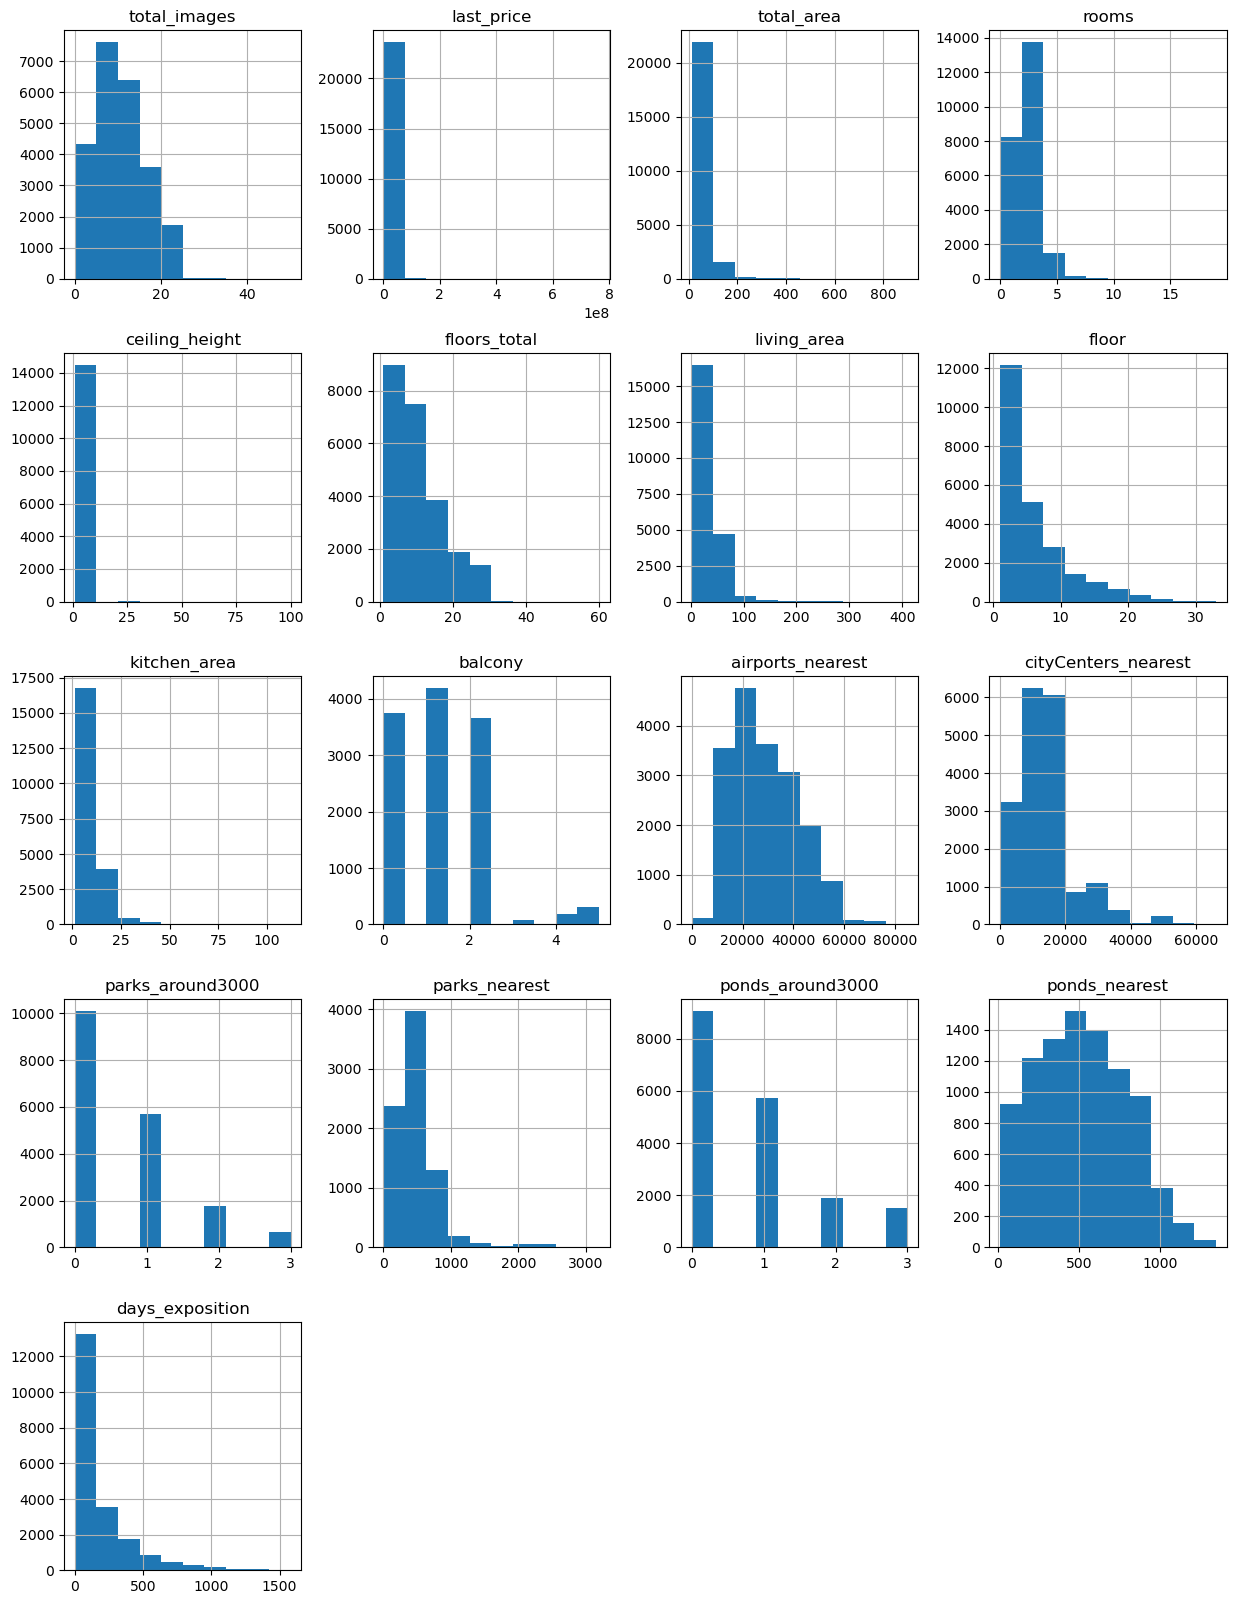

In [1]:
import pandas as pd
data = pd.read_csv('C:\\StudentYandex\\Projekts\\Python\\Projekt3Home\\real_estate_data.csv', sep = '\t')
data.info()
data.hist(figsize=(15, 20))
import matplotlib.pyplot as plt
plt.show()
import warnings
warnings.filterwarnings("ignore")

### Предобработка данных

**Пропущенные значения**

Определим в каких столбцах имеются пропуски

In [2]:
data.isna().sum()

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height           9195
floors_total               86
living_area              1903
floor                       0
is_apartment            20924
studio                      0
open_plan                   0
kitchen_area             2278
balcony                 11519
locality_name              49
airports_nearest         5542
cityCenters_nearest      5519
parks_around3000         5518
parks_nearest           15620
ponds_around3000         5518
ponds_nearest           14589
days_exposition          3181
dtype: int64

In [3]:
pd.DataFrame(round(data.isna().mean()*100,1)).style.background_gradient('coolwarm')

,0
total_images,0.000000
last_price,0.000000
total_area,0.000000
first_day_exposition,0.000000
rooms,0.000000
ceiling_height,38.800000
floors_total,0.400000
living_area,8.000000
floor,0.000000
is_apartment,88.300000


Пропусков в данных достаточно много, рассмотрим их

Стобец `ceiling_height` - высота потолков. В первую очередь посмотрим описание числовых данных столбца.

In [4]:
print(data['ceiling_height'].describe())

count    14504.000000
mean         2.771499
std          1.261056
min          1.000000
25%          2.520000
50%          2.650000
75%          2.800000
max        100.000000
Name: ceiling_height, dtype: float64


Пропуски в столбце `ceiling_height` заполним медианным значением, т.к. "среднее" исказит данные вверх, из-за наличия "артефактов".

In [5]:
data['ceiling_height'] = data['ceiling_height'].fillna(data['ceiling_height'].median())

Пропущенные значение в столбцах:

* `airports_nearest`, `cityCenters_nearest`, `parks_nearest`, `ponds_nearest` - данные отсутствуют, по всей видимости, из-за того, что таких объектов вблизи дома нет;

Оставим их пустыми.

Столбец `floors_total` - всего этажей в доме, показатель важный, но всего 86 (меннее 0,3% всего датафрейма) строк. Есть квартиры и на 1 и на 20 этажах, заполнить значением из `floor` не можем, т.к. исказит данные. Поэтому придется избавится от этих строк.

Так же придется поступить с `locality_name` - название населенного пункта, показатель важный, но всего 49 (меннее 0,2% всего датафрейма) строк - не сильно повлияет на исследование.

In [6]:
data = data.dropna(subset = ['floors_total', 'locality_name'])

В столбце `is_apartment` пропущенные значения - это пропуск при заполнении параметров квартиры, там где значения пропущенны - это не аппартаменты, меняем на "False":

In [7]:
data.loc[data['is_apartment'].isna(), 'is_apartment'] = 'False'


Далее рассмотрим столбец `balcony`:

In [8]:
data[data['balcony'].isna()].head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.00,2019-03-07T00:00:00,3,2.70,16.0,51.00,8,False,...,25.00,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
4,2,10000000.0,100.00,2018-06-19T00:00:00,2,3.03,14.0,32.00,13,False,...,41.00,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0
5,10,2890000.0,30.40,2018-09-10T00:00:00,1,2.65,12.0,14.40,5,False,...,9.10,NaN,городской посёлок Янино-1,NaN,NaN,NaN,NaN,NaN,NaN,55.0
8,20,2900000.0,33.16,2018-05-23T00:00:00,1,2.65,27.0,15.43,26,False,...,8.81,NaN,посёлок Мурино,NaN,NaN,NaN,NaN,NaN,NaN,189.0
10,5,5050000.0,39.60,2017-11-16T00:00:00,1,2.67,12.0,20.30,3,False,...,8.50,NaN,Санкт-Петербург,38357.0,13878.0,1.0,310.0,2.0,553.0,137.0


В полученной вырезке видим, что квартиры располагаются на разных этажах. Информация о балконе пропущена при заполнении параметров квартиры(Человеческий фактор). Заменим пропуски в данном столбце на "0", то есть балкон отсутствует.

Пропуски в столбце `days_exposition`, так же заполним "0". Пропуск означает что объявление было снято в день размещения.

Пропуски в столбцах `parks_around3000` и `ponds_around3000` меняем на "0". Т.к. данных объектов рядом нет.

In [9]:
columns = ['balcony', 'days_exposition', 'parks_around3000', 'ponds_around3000']
for column in columns:
    data[column] = data[column].fillna(0)

Вычислим по всем датафрейму какой средний коэффициент отношения общей площади к жилой, и по этим данным заполним пропущенные значения в `living_area`. Так же поступим и с `kitchen_area` 

In [10]:
data.loc[data['living_area'].isna(),'living_area'] = \
data['total_area']*((data['living_area']/data['total_area']).median())
data.loc[data['kitchen_area'].isna(),'kitchen_area'] = \
data['total_area']*((data['kitchen_area']/data['total_area']).median())
data.isna().sum()

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height              0
floors_total                0
living_area                 0
floor                       0
is_apartment                0
studio                      0
open_plan                   0
kitchen_area                0
balcony                     0
locality_name               0
airports_nearest         5524
cityCenters_nearest      5501
parks_around3000            0
parks_nearest           15535
ponds_around3000            0
ponds_nearest           14529
days_exposition             0
dtype: int64

**Типы данных**

Типы данных в стобце `first_day_exposition` приведем к формату datetime

In [11]:
data['first_day_exposition'] = pd.to_datetime(data['first_day_exposition'], format = '%Y-%m-%dT%H:%M:%S')

Типы данных в стобце `floors_total` приведем к формату 'int', т.к. это значение может быть только целым. Мы же не видели никогда 1,5 или 2,5 этажные дома. 

In [12]:
data['floors_total'] = data['floors_total'].astype('int')

Столбец `is_apartment` его тип object, но должен быть bool - меняем. 

In [13]:
data['is_apartment'] = data['is_apartment'].astype('bool')

Количество балконов так же не бывает, 1,5 и 2,5 меняем на 'int'

In [14]:
data['balcony'] = data['balcony'].astype('int')

Так же и столбцы `parks_around3000` и `ponds_around3000` 

In [15]:
data['parks_around3000'] = data['parks_around3000'].astype('int')
data['ponds_around3000'] = data['ponds_around3000'].astype('int')

Поменяем тип данных в столбцах `airports_nearest, cityCenters_nearest, parks_nearest, ponds_nearest` на 'float'

In [16]:
columns = [
    'airports_nearest', 'cityCenters_nearest', 'parks_nearest', 'ponds_nearest'
]
for column in columns:
    data[column] = data[column].astype('float')

**Поиск дубликатов**

Найдем явные дубликаты

In [17]:
data.duplicated().sum()

0

Явных дубликатов в Датасете не имеется. Найдем неявные дубликаты. Судя по значению столбцов, мы можем столкнуться с дубликатами в `locality_name`. Рассмотрим уникальные значения столбца:

In [18]:
print(len(data['locality_name'].sort_values().unique()))
data['locality_name'].sort_values().unique()

364


array(['Бокситогорск', 'Волосово', 'Волхов', 'Всеволожск', 'Выборг',
       'Высоцк', 'Гатчина', 'Зеленогорск', 'Ивангород', 'Каменногорск',
       'Кингисепп', 'Кириши', 'Кировск', 'Колпино', 'Коммунар',
       'Красное Село', 'Кронштадт', 'Кудрово', 'Лодейное Поле',
       'Ломоносов', 'Луга', 'Любань', 'Мурино', 'Никольское',
       'Новая Ладога', 'Отрадное', 'Павловск', 'Петергоф', 'Пикалёво',
       'Подпорожье', 'Приморск', 'Приозерск', 'Пушкин', 'Санкт-Петербург',
       'Светогорск', 'Сертолово', 'Сестрорецк', 'Сланцы', 'Сосновый Бор',
       'Сясьстрой', 'Тихвин', 'Тосно', 'Шлиссельбург',
       'городской поселок Большая Ижора', 'городской поселок Янино-1',
       'городской посёлок Будогощь', 'городской посёлок Виллози',
       'городской посёлок Лесогорский', 'городской посёлок Мга',
       'городской посёлок Назия', 'городской посёлок Новоселье',
       'городской посёлок Павлово', 'городской посёлок Рощино',
       'городской посёлок Свирьстрой', 'городской посёлок Совет

В полученном списке, видим, что имеются задвоения, например "городской поселок" и "поселок городского типа", так же "посёлок" и "поселок" и т.п. Устраним данные дубликаты

In [19]:
data['locality_name'] = data['locality_name'].str.replace('посёлок','поселок')
data['locality_name'] = data['locality_name'].str.replace('городской поселок','поселок городского типа')
print(len(data['locality_name'].sort_values().unique()))

323


**Аномальные значения**

Теперь когда мы избавились от пропусков и дубликатов, посмотрим снова информацию о датафрейме.

In [20]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23565 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          23565 non-null  int64         
 1   last_price            23565 non-null  float64       
 2   total_area            23565 non-null  float64       
 3   first_day_exposition  23565 non-null  datetime64[ns]
 4   rooms                 23565 non-null  int64         
 5   ceiling_height        23565 non-null  float64       
 6   floors_total          23565 non-null  int32         
 7   living_area           23565 non-null  float64       
 8   floor                 23565 non-null  int64         
 9   is_apartment          23565 non-null  bool          
 10  studio                23565 non-null  bool          
 11  open_plan             23565 non-null  bool          
 12  kitchen_area          23565 non-null  float64       
 13  balcony         

Рассмотрим числовые значения в столбцах.

In [21]:
for column in data.columns:
    print(data[column].describe())
import warnings
warnings.filterwarnings("ignore")

count    23565.000000
mean         9.878421
std          5.681156
min          0.000000
25%          6.000000
50%          9.000000
75%         14.000000
max         50.000000
Name: total_images, dtype: float64
count    2.356500e+04
mean     6.540058e+06
std      1.091093e+07
min      1.219000e+04
25%      3.400000e+06
50%      4.646000e+06
75%      6.790000e+06
max      7.630000e+08
Name: last_price, dtype: float64
count    23565.000000
mean        60.322824
std         35.657060
min         12.000000
25%         40.000000
50%         52.000000
75%         69.700000
max        900.000000
Name: total_area, dtype: float64
count                   23565
unique                   1489
top       2018-02-01 00:00:00
freq                      366
first     2014-11-27 00:00:00
last      2019-05-03 00:00:00
Name: first_day_exposition, dtype: object
count    23565.000000
mean         2.070656
std          1.078591
min          0.000000
25%          1.000000
50%          2.000000
75%          3.00

Построим диаграммы размаха для столбцов с сильным отклонением.

<AxesSubplot:>

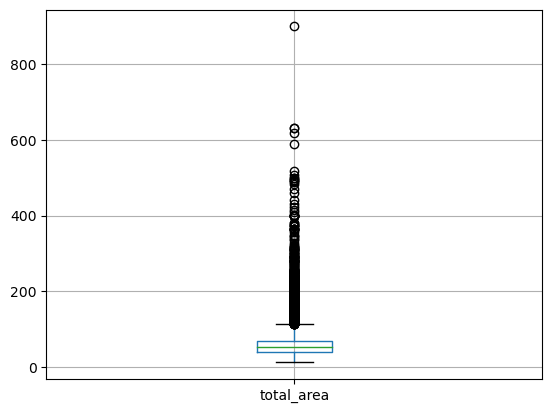

In [22]:
data.boxplot('total_area')

Видим что есть выбросы свыше 120 квадратных метров, но до 400 они постоянны, а потом становятся более редкими.

Исключим квартиры площадью свыше 400 квадратных метров.

In [23]:
data = data.query('total_area < 400')

`rooms` - минимальное количество комнат 0, а максимальное - 19 штук.

<AxesSubplot:>

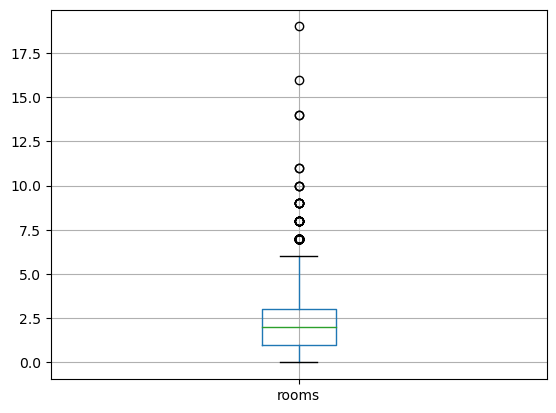

In [24]:
data.boxplot('rooms')

На диаграмме видим что выбивающиеся значения это количество комнат - свыше 6. Исключим их из анализа.

In [25]:
data = data.query('rooms <= 6')

Посмотрим на строки, где 0 комнат `rooms` .

In [26]:
data[data['rooms'] == 0]

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
144,1,2450000.0,27.00,2017-03-30,0,2.65,24,15.50000,2,True,...,4.653789,2,поселок Мурино,NaN,NaN,0,NaN,0,NaN,181.0
349,4,2320000.0,25.00,2017-09-27,0,2.65,14,17.00000,1,True,...,4.309064,0,деревня Кудрово,NaN,NaN,0,NaN,0,NaN,45.0
440,8,2480000.0,27.11,2018-03-12,0,2.65,17,24.75000,4,True,...,4.672749,2,Санкт-Петербург,38171.0,15015.0,0,NaN,2,982.0,64.0
508,0,3375000.0,34.40,2017-03-28,0,2.65,26,24.30000,19,True,...,5.929272,1,поселок Парголово,53115.0,19292.0,0,NaN,1,593.0,430.0
608,2,1850000.0,25.00,2019-02-20,0,2.65,10,14.20525,7,True,...,4.309064,0,поселок Шушары,NaN,NaN,0,NaN,0,NaN,29.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23210,7,3200000.0,26.00,2017-09-01,0,2.65,25,18.00000,16,True,...,4.481426,0,Санкт-Петербург,11405.0,13222.0,0,NaN,1,623.0,14.0
23442,0,2500000.0,27.70,2017-09-28,0,2.65,24,18.00000,4,True,...,4.774443,2,поселок Мурино,NaN,NaN,0,NaN,0,NaN,4.0
23554,15,3350000.0,26.00,2018-09-07,0,2.65,19,14.77346,8,True,...,4.481426,0,Санкт-Петербург,18090.0,17092.0,0,NaN,2,112.0,31.0
23592,10,1450000.0,29.00,2017-11-11,0,2.65,9,18.00000,8,True,...,4.998514,2,Никольское,NaN,NaN,0,NaN,0,NaN,82.0


Из полученных строк видим, что это аппартаменты, выставим количество комнат равное "1":

In [27]:
data.loc[data['rooms'] == 0,'rooms'] = 1

Далее рассмотрим высоту потолков столбец `ceiling_height`, выставим фильтр, минимальная высота 2 м максимальная 5 м:

In [28]:
data.loc[(data['ceiling_height']<2) | (data['ceiling_height']>5)].head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
355,17,3600000.0,55.2,2018-07-12,2,25.0,5,32.000000,2,False,...,9.514413,2,Гатчина,NaN,NaN,0,NaN,0,NaN,259.0
464,15,66571000.0,280.3,2015-06-11,6,5.2,8,159.500000,7,True,...,21.100000,0,Санкт-Петербург,26316.0,6655.0,3,187.0,1,616.0,578.0
1026,20,155000000.0,310.0,2018-10-12,5,5.3,3,190.000000,3,True,...,63.000000,2,Санкт-Петербург,24899.0,4785.0,0,NaN,1,603.0,0.0
1388,20,59800000.0,399.0,2015-01-21,5,5.6,6,226.715796,6,True,...,68.772660,0,Санкт-Петербург,26204.0,6934.0,2,149.0,2,577.0,719.0
3148,14,2900000.0,75.0,2018-11-12,3,32.0,3,53.000000,2,True,...,8.000000,0,Волхов,NaN,NaN,0,NaN,0,NaN,0.0


В таблице видно, что есть логичные отклонения, например вместо 2,7 м заполнили 27 м. В первую очередь разберемся с ними. Все значения свыше 5 м разделим на 10. Остальное заполним медианным значением.

In [29]:
data.loc[data['ceiling_height']>5, 'ceiling_height'] = data['ceiling_height']/10
data.loc[(data['ceiling_height']<2) | (data['ceiling_height']>5),'ceiling_height'] = data['ceiling_height'].median()

Рассмотрим столбец `last_price`:

<AxesSubplot:>

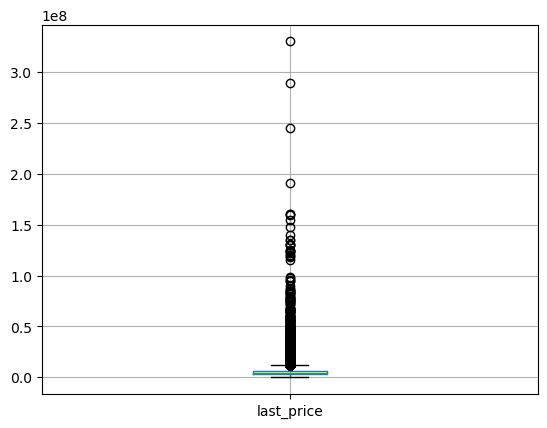

In [30]:
data.boxplot('last_price')

В стоимости так же есть выбросы, но цена квартир очень важна для исследования. Поэтому удалять эти строки из таблицы не будем

`living_area` - жилая площадь.

<AxesSubplot:>

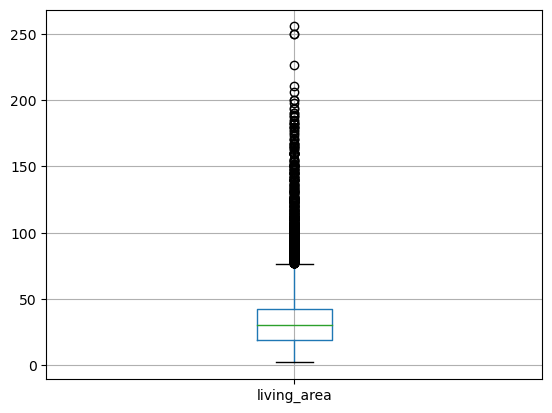

In [31]:
data.boxplot('living_area')

Уберем выбросы свыше 200 квадратных метров

In [32]:
data = data.query('living_area < 200')

`kitchen_area` - площадь кухни.

<AxesSubplot:>

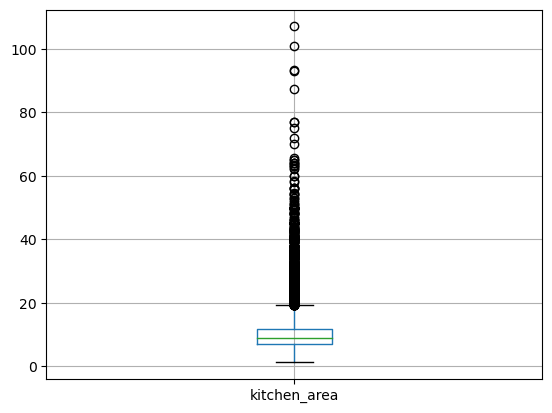

In [33]:
data.boxplot('kitchen_area')

Уберем выбросы свыше 70 квадратных метров

In [34]:
data = data.query('kitchen_area < 70')

### Посчитаем и добавим в таблицу новые столбцы

**Добавляем столбцы необходимые для исследования**

Вычислим и добавим цену одного квадратного метра - столбец `price_one_meter`

In [35]:
data['price_one_meter'] = data['last_price']/data['total_area']

День недели когда было опубликовано объявление `day_of_the_week`

In [36]:
data['day_of_the_week'] = data['first_day_exposition'].dt.weekday

Месяц когда было опубликованно объявление `month`

In [37]:
data['month'] = data['first_day_exposition'].dt.month

Год публикации объявления `year`

In [38]:
data['year'] = data['first_day_exposition'].dt.year

Тип этажа квартиры "первый", "последний", "другой" `floor_type`

In [39]:
def floor_types(df):
    if df['floor'] == 1:
        return 'первый'
    elif df['floor'] == df['floors_total']:
        return 'последний'
    return 'другой'

In [40]:
data['floor_type'] = data.apply(floor_types, axis=1)

Дистанция от центра города в км `distance_in_km`

Видим что дистанция указанна в метрах, преобразуем в километры

In [41]:
data['distance_in_km'] = data['cityCenters_nearest']/1000

### Исследовательский анализ данных

Изучим параметры:
  - общая площадь;
  - жилая площадь;
  - площадь кухни;
  - цена объекта;
  - количество комнат;
  - высота потолков;
  - этаж квартиры;
  - тип этажа квартиры («первый», «последний», «другой»);
  - общее количество этажей в доме;
  - расстояние до центра города в метрах;
  - расстояние до ближайшего аэропорта;
  - расстояние до ближайшего парка;
  - день и месяц публикации объявления.
  
  Для того чтобы рассмотреть диаграммы по данным параметрам создадим новый дата фрейм data_final

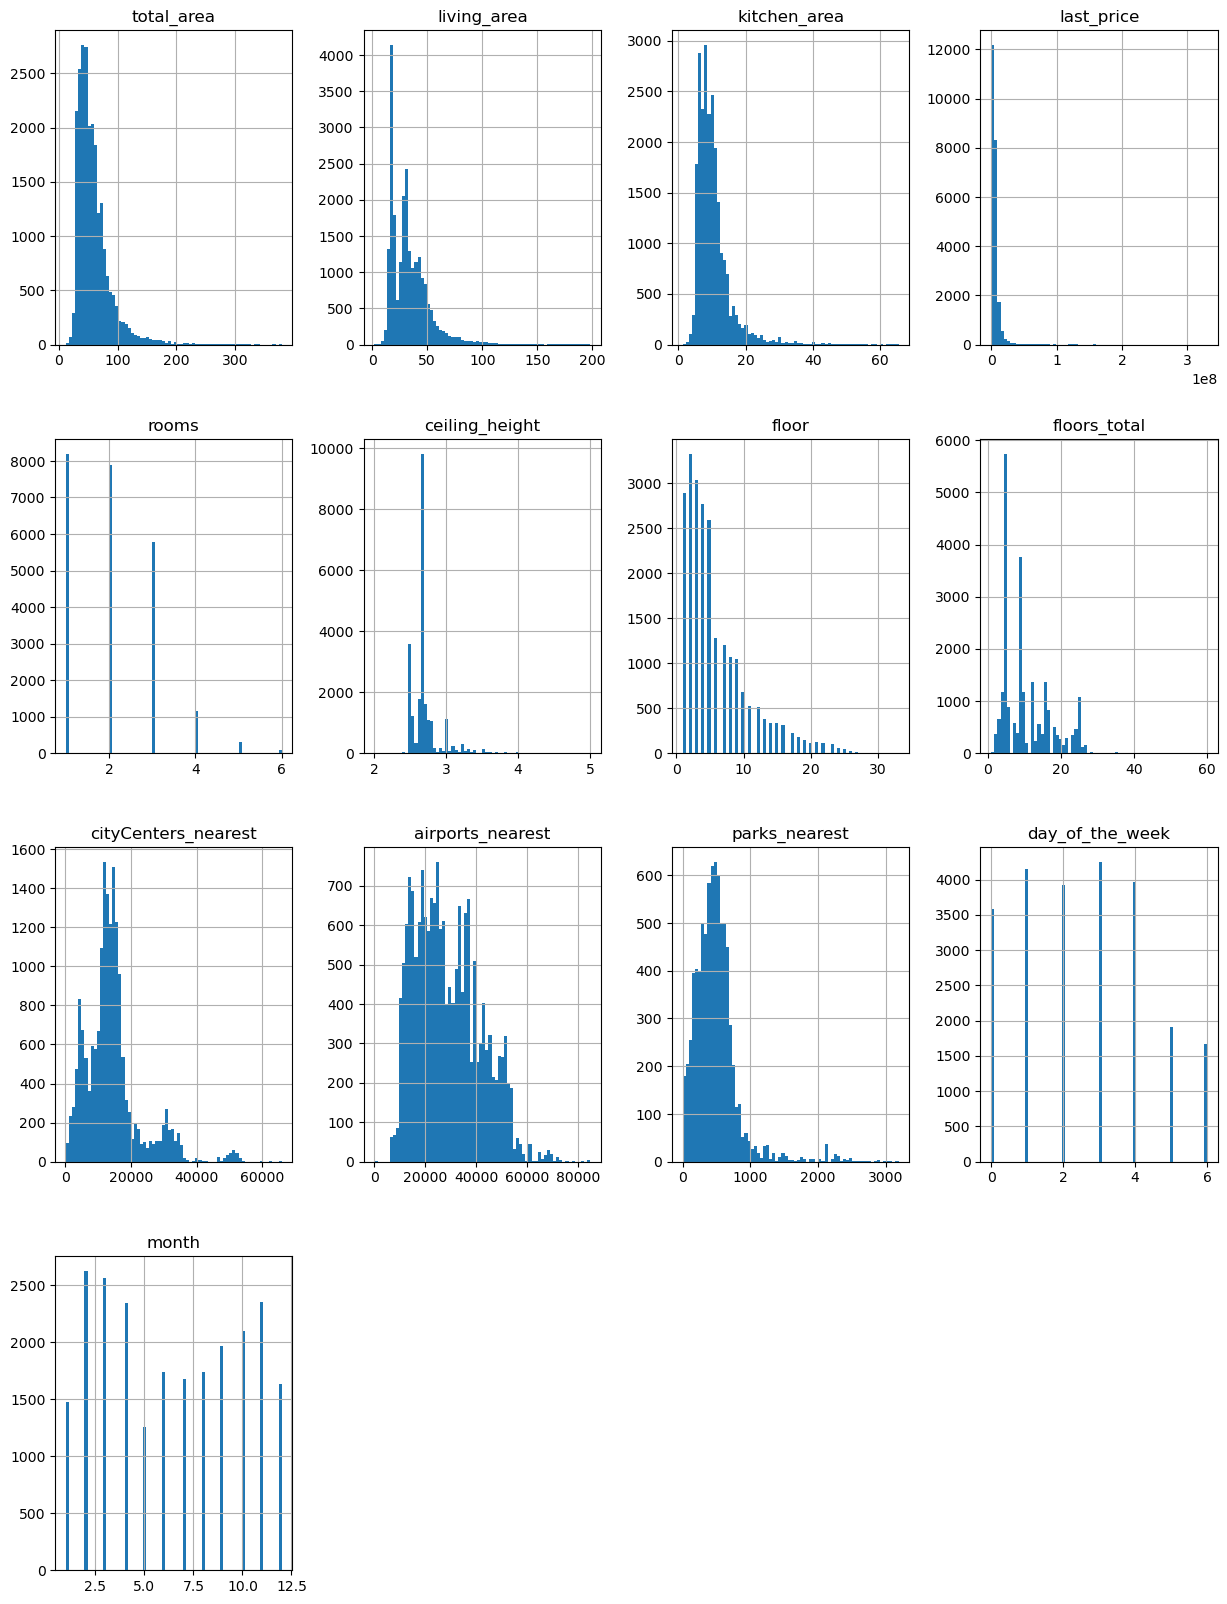

In [42]:
data_final = data[
    ['total_area', 'living_area', 'kitchen_area', 'last_price', 'rooms', 'ceiling_height', 'floor', 'floor_type', \
     'floors_total', 'cityCenters_nearest', 'airports_nearest', 'parks_nearest', 'day_of_the_week', 'month']
]
data_final.hist(bins=70, figsize=(15, 20))
plt.show()

Построив гистрограмму `total_area` видим что больше предложений на квартиры площадью ~ 50 квадратных метров. Остались выбивающиеся значения, т.к. такие объекты на рынке время от времени появляются.

`living_area`,`kitchen_area` - жилая площадь и площадь кухни, зависят от `total_area`. Больше всего объявлений на квартиры с жилой площадью ~ 20 квадратных метров, площадь кухни ~ 10 квадратных метров.

`last_price` - цена варьируется, но больше предложений со стоимостью свыше 12 000 000 руб.

`rooms` - количество комнат, наиболее распространнены объявления по продаже однокомнатных и двухкомнатных квартир.

`ceiling_height`- высота потолков, наиболее распространнены квартиры с медианным значением.

`floor`- этаж расположения квартиры, больше объектов находящихся на 3 этаже.

`floors_total` - дома в которых продают квартиры в основном пятиэтажные.

`cityCenters_nearest` - большинство объектов находятся в 10-20 км от центра города.

`airports_nearest` - расстояние до аэропорта в среднем 10-30 км.

`parks_nearest` - парки в основном в шаговой доступности, до 1 км.

`day_of_the_week` - объявления публикуются чаще по будням, в выходные в 2 раза реже.

`month` - количество объявлений с февраля по май уменьшается, но потом начинает расти вплоть до ноября.

Не была построенна гистрограмма по столбцу `floor_type` т.к. тип данных в столбце str. Сделаем сводную таблицу по данному столбцу и построим график.

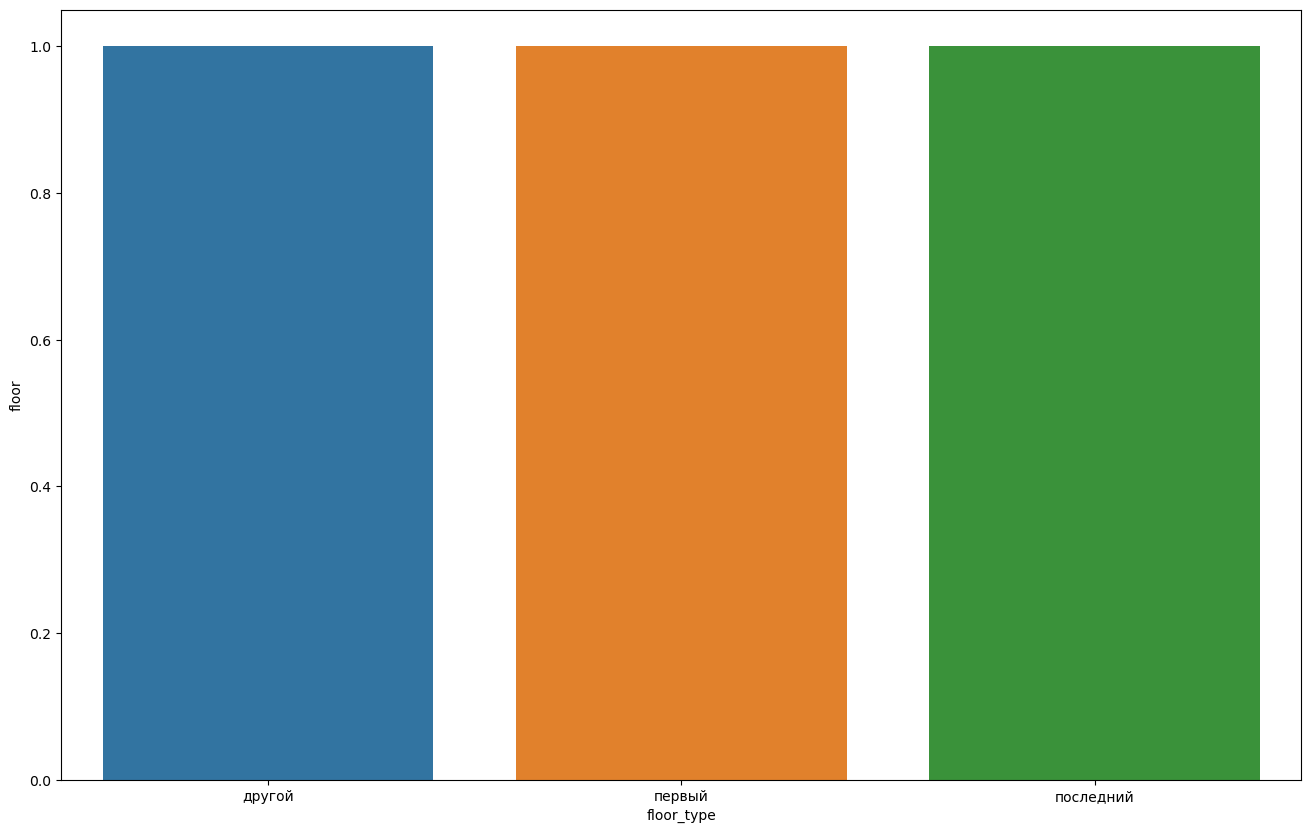

In [56]:
data_final = data_final.pivot_table(index='floor_type', values='floor', aggfunc='count')
import seaborn
plt.figure(figsize=(16, 10))
seaborn.barplot(x=data_final.index, y=data_final['floor'])
plt.show()

`floor_type` - больше всего объявлений с квартирами на Другом этаже, на Первом этаже всех меньше объявлений.

Посмотрим как быстро продавались квартиры

count    23444.000000
mean       156.215791
std        213.144467
min          0.000000
25%         22.000000
50%         73.000000
75%        198.000000
max       1580.000000
Name: days_exposition, dtype: float64

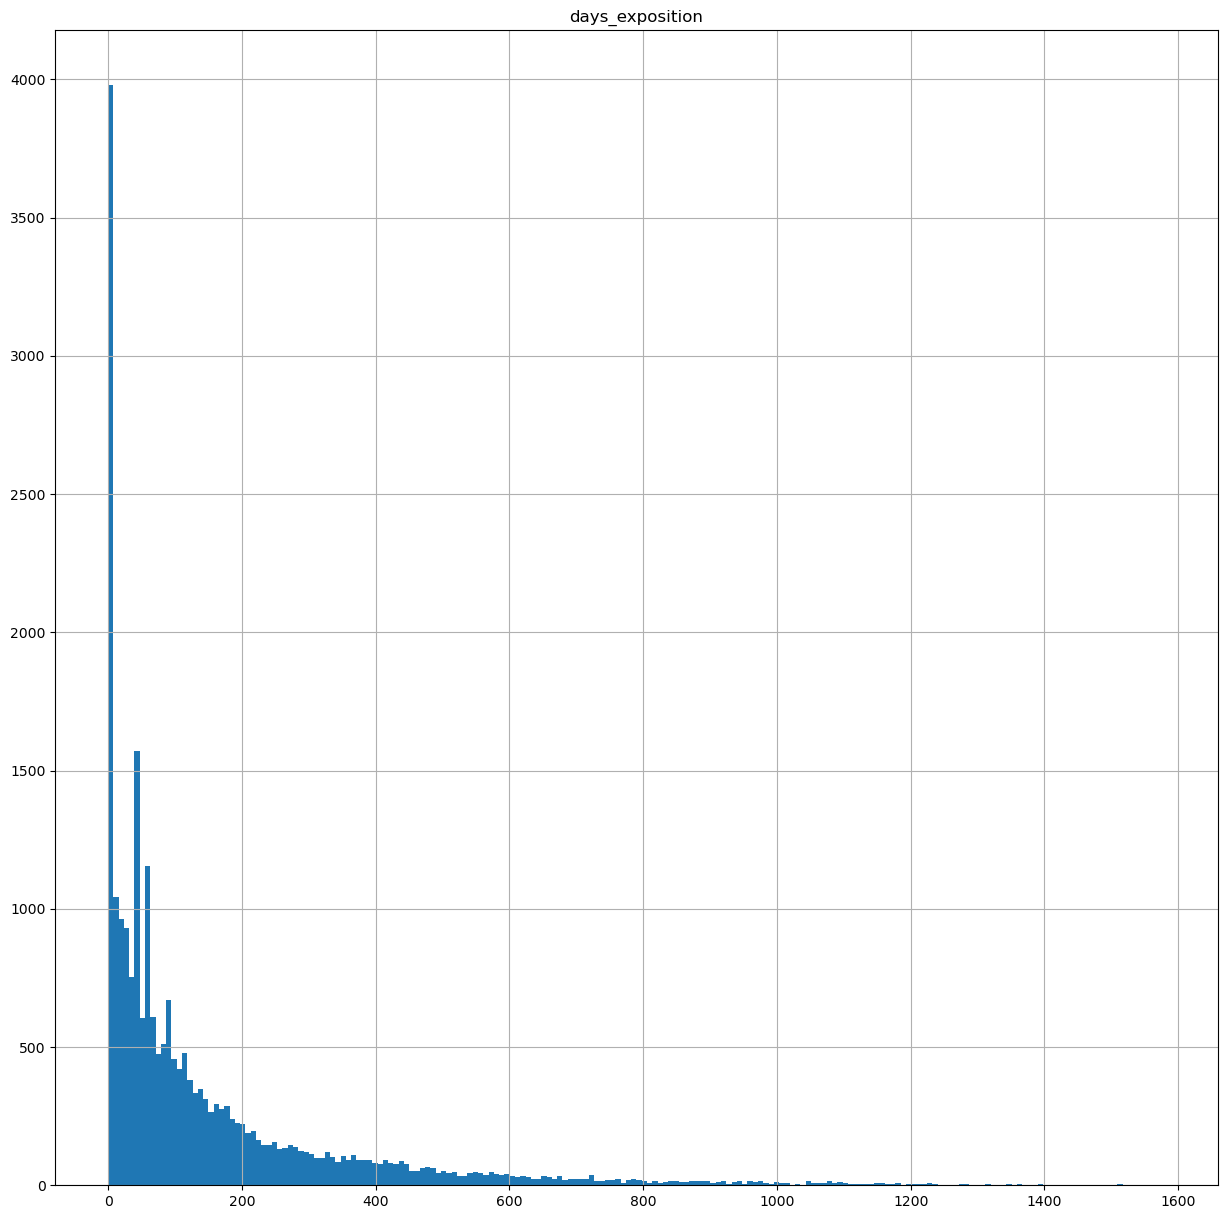

In [44]:
data.hist('days_exposition', bins=200, figsize=(15,15))
data['days_exposition'].describe()

array([[<AxesSubplot:title={'center':'days_exposition'}>]], dtype=object)

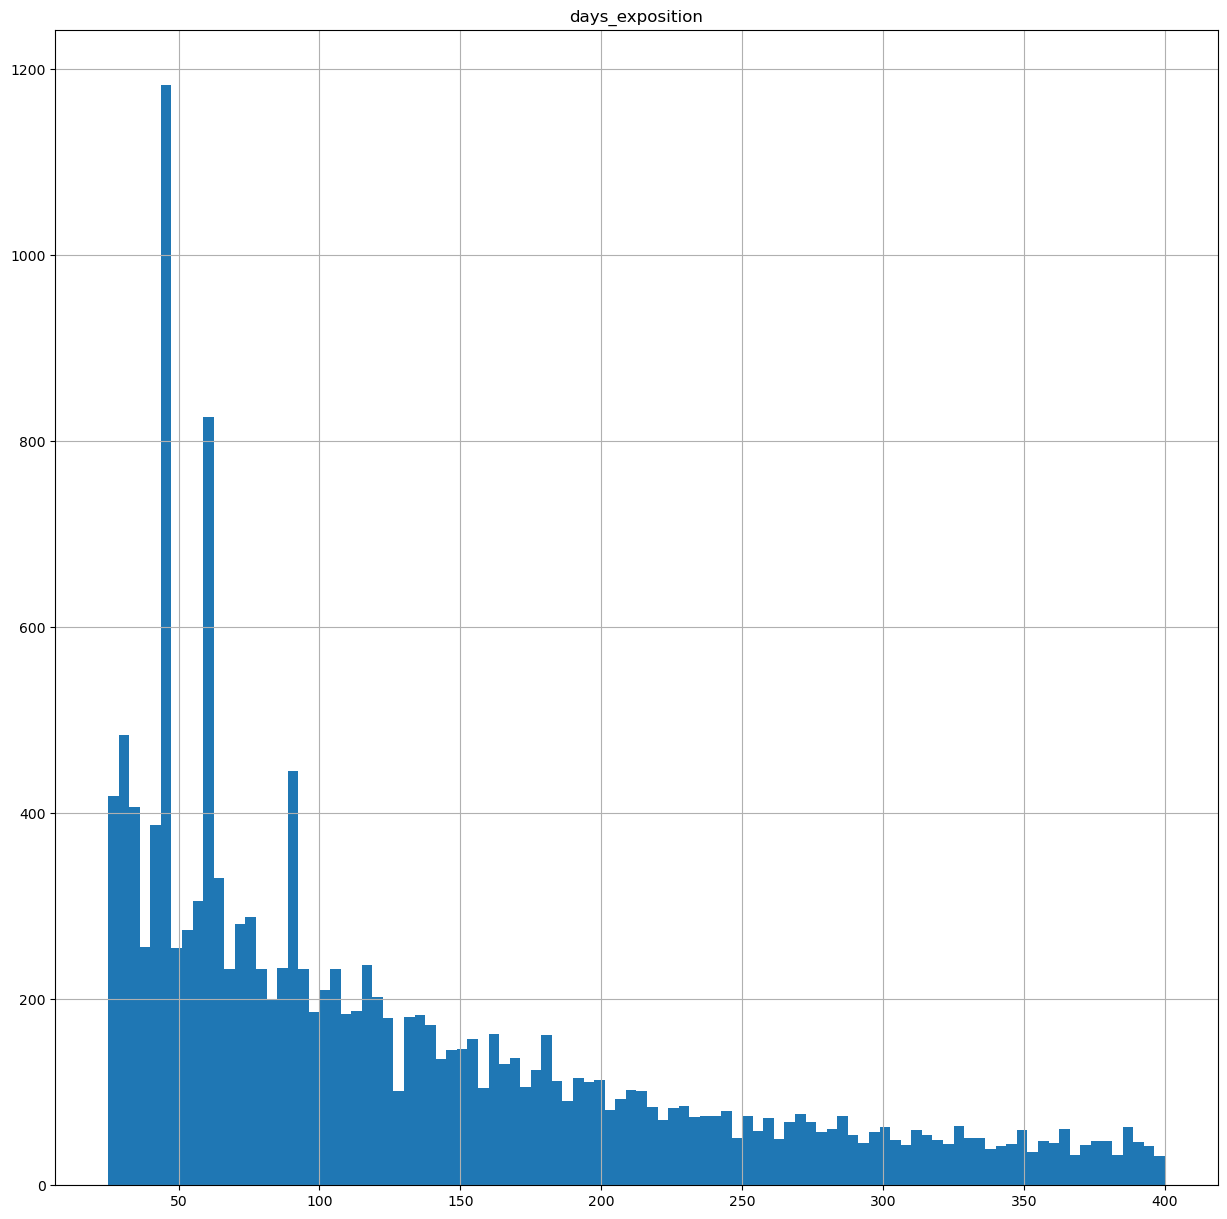

In [45]:
data.hist('days_exposition', bins=100, range = (25,400), figsize=(15,15))

Посмотрев на гистограммы, можем сделать несколько выводов:
* Продажа обычнор занимает 45 дней;
* Быстрыми можно считать продажи до 22 дней;
* Необычно долгие продажи - свыше 198 дней.

Какие факторы больше всего влияют на общую (полную) стоимость объекта? Построим графики, которые покажут зависимость цены от указанных ниже параметров.
  - общей площади;
  - жилой площади;
  - площади кухни;
  - количество комнат;
  - типа этажа, на котором расположена квартира (первый, последний, другой);
  - даты размещения (день недели, месяц, год);

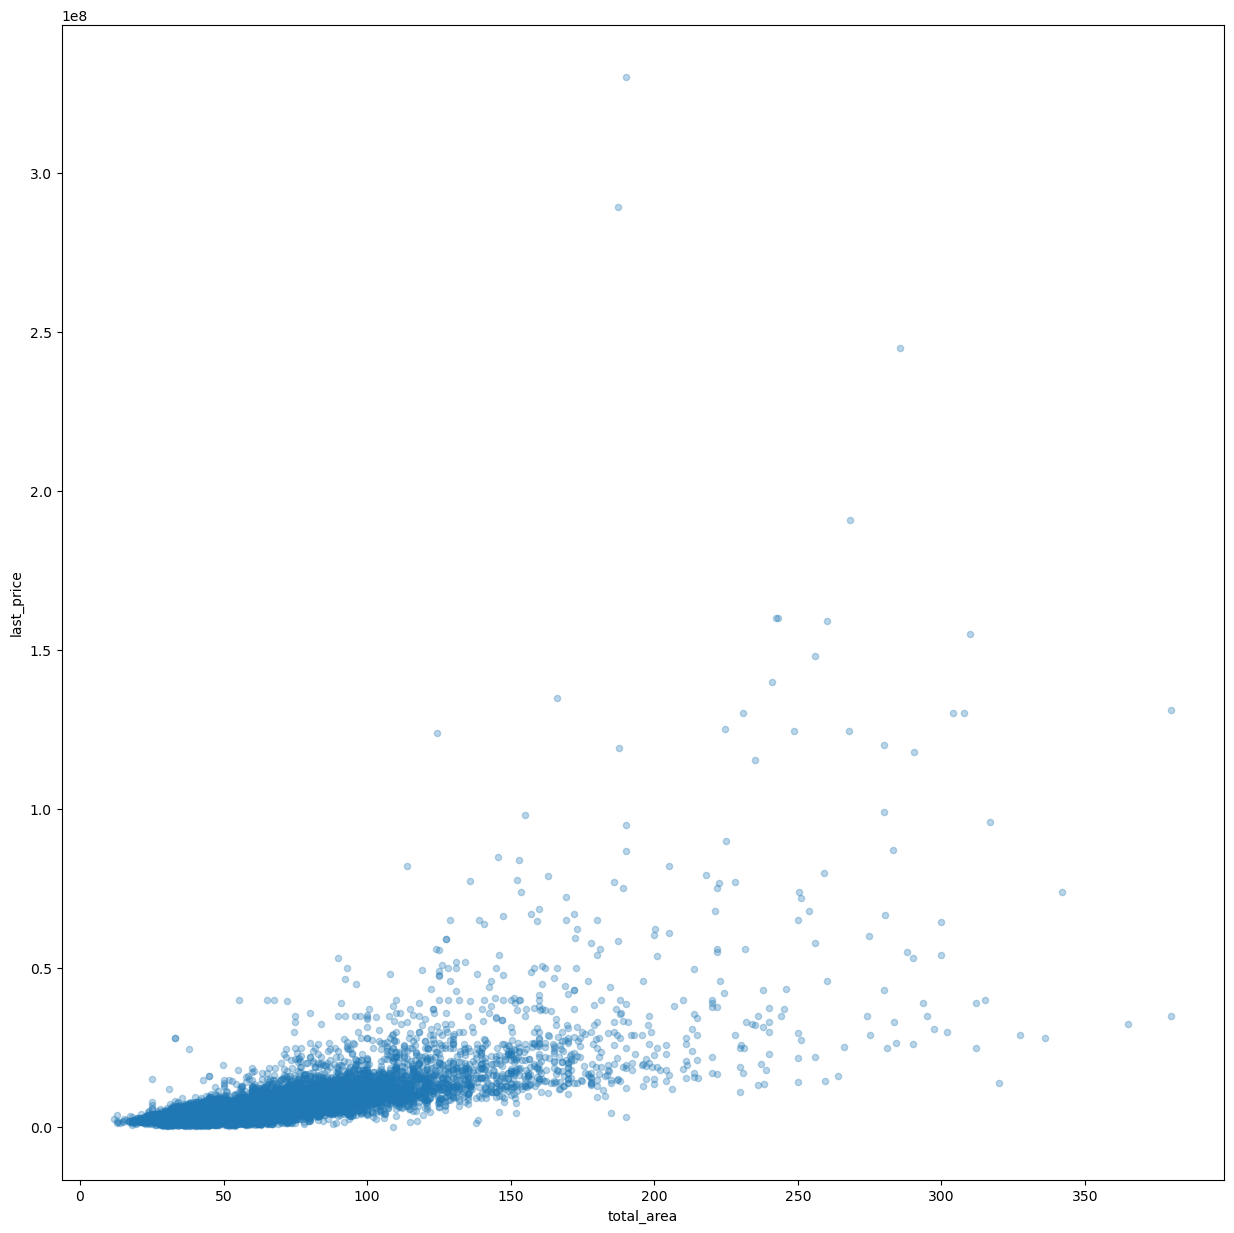

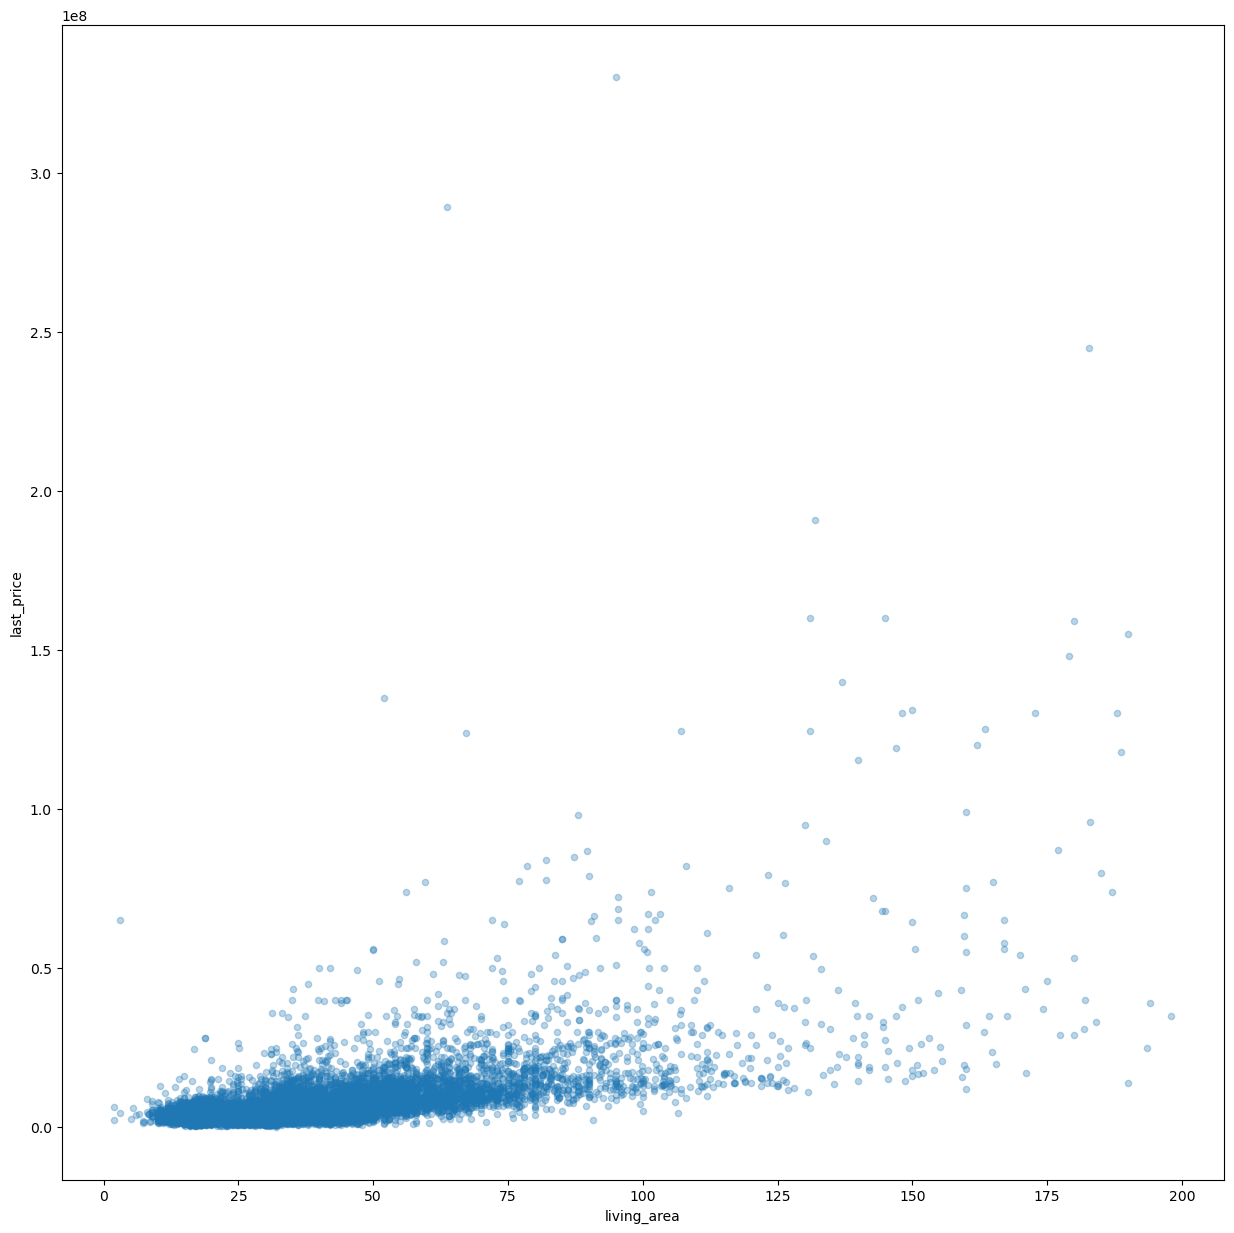

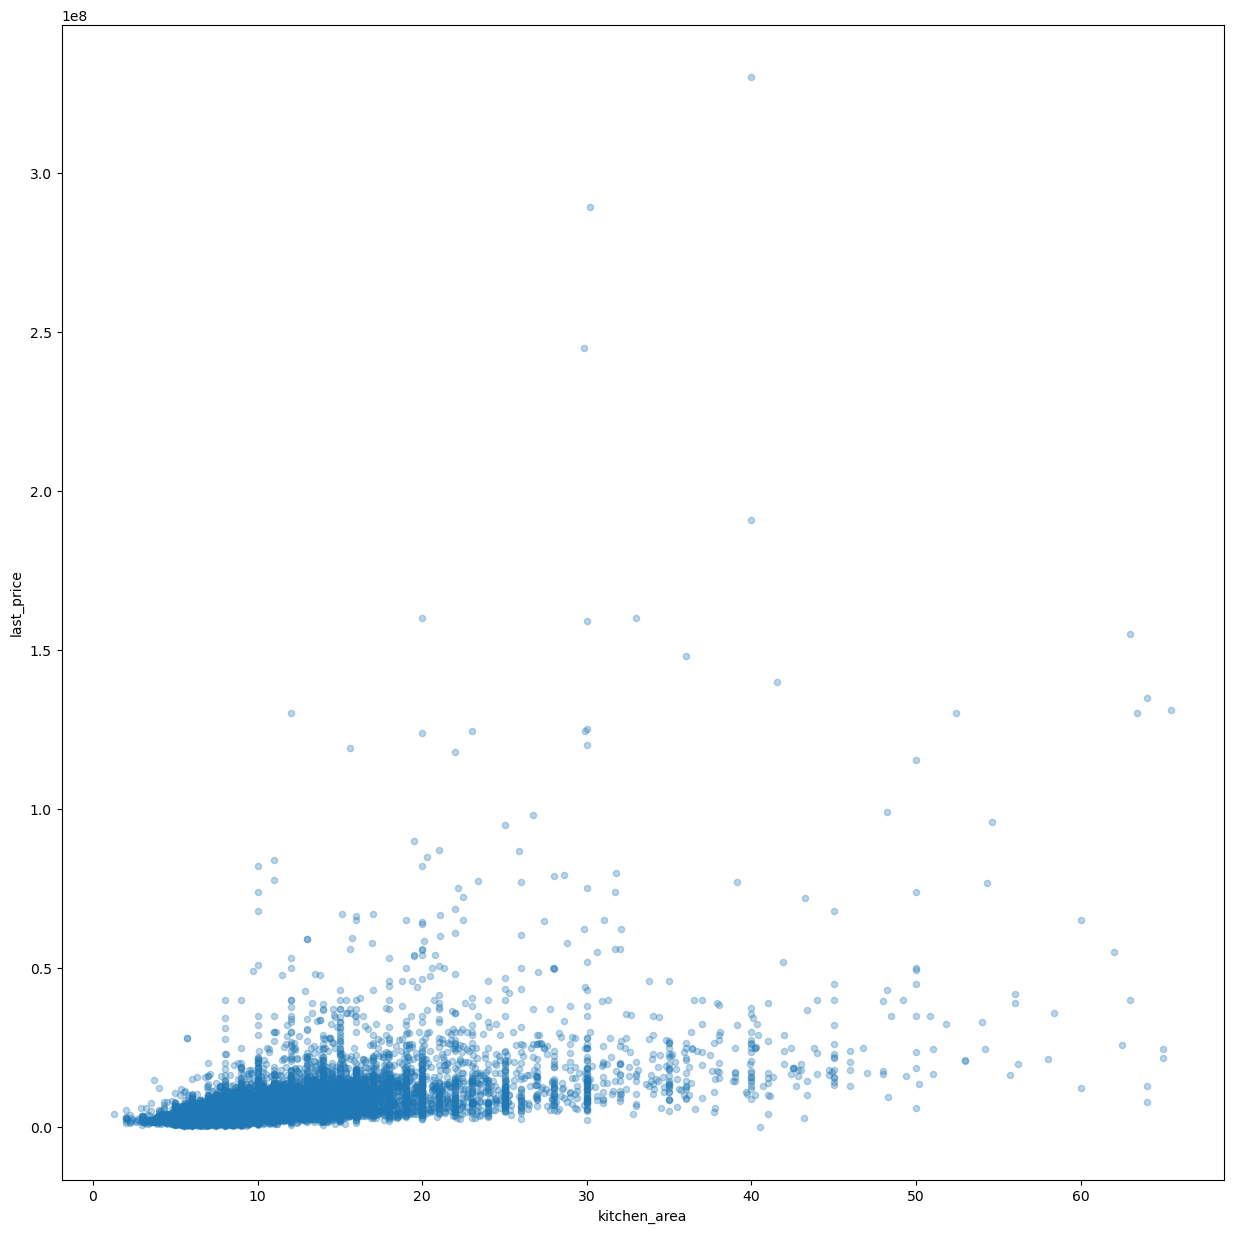

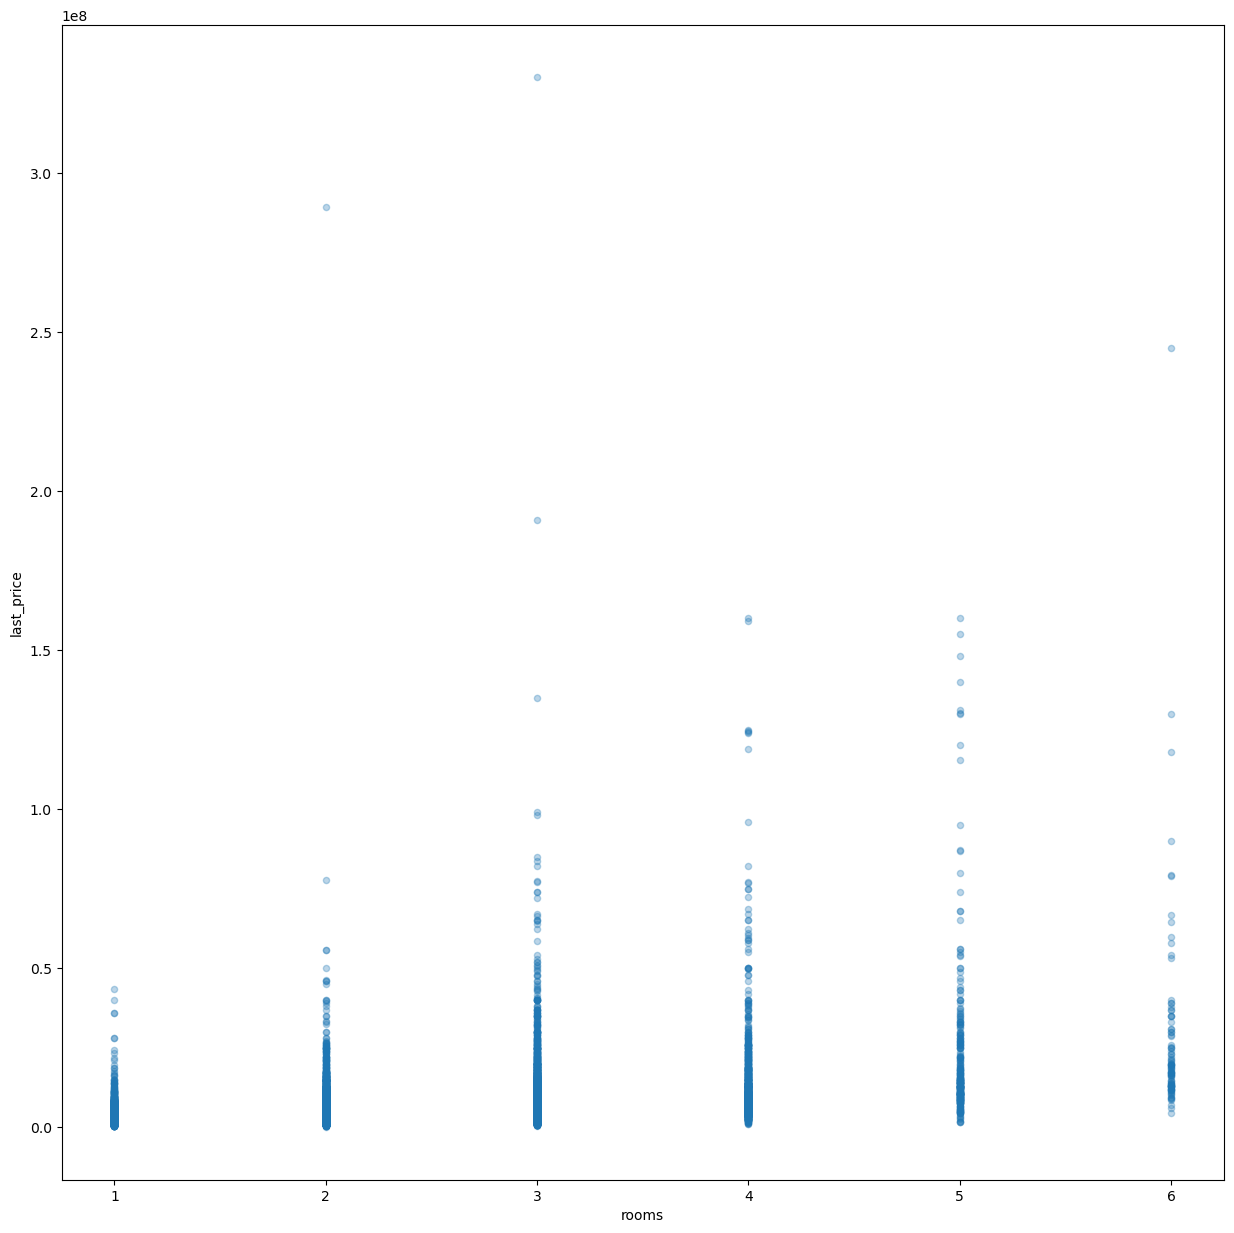

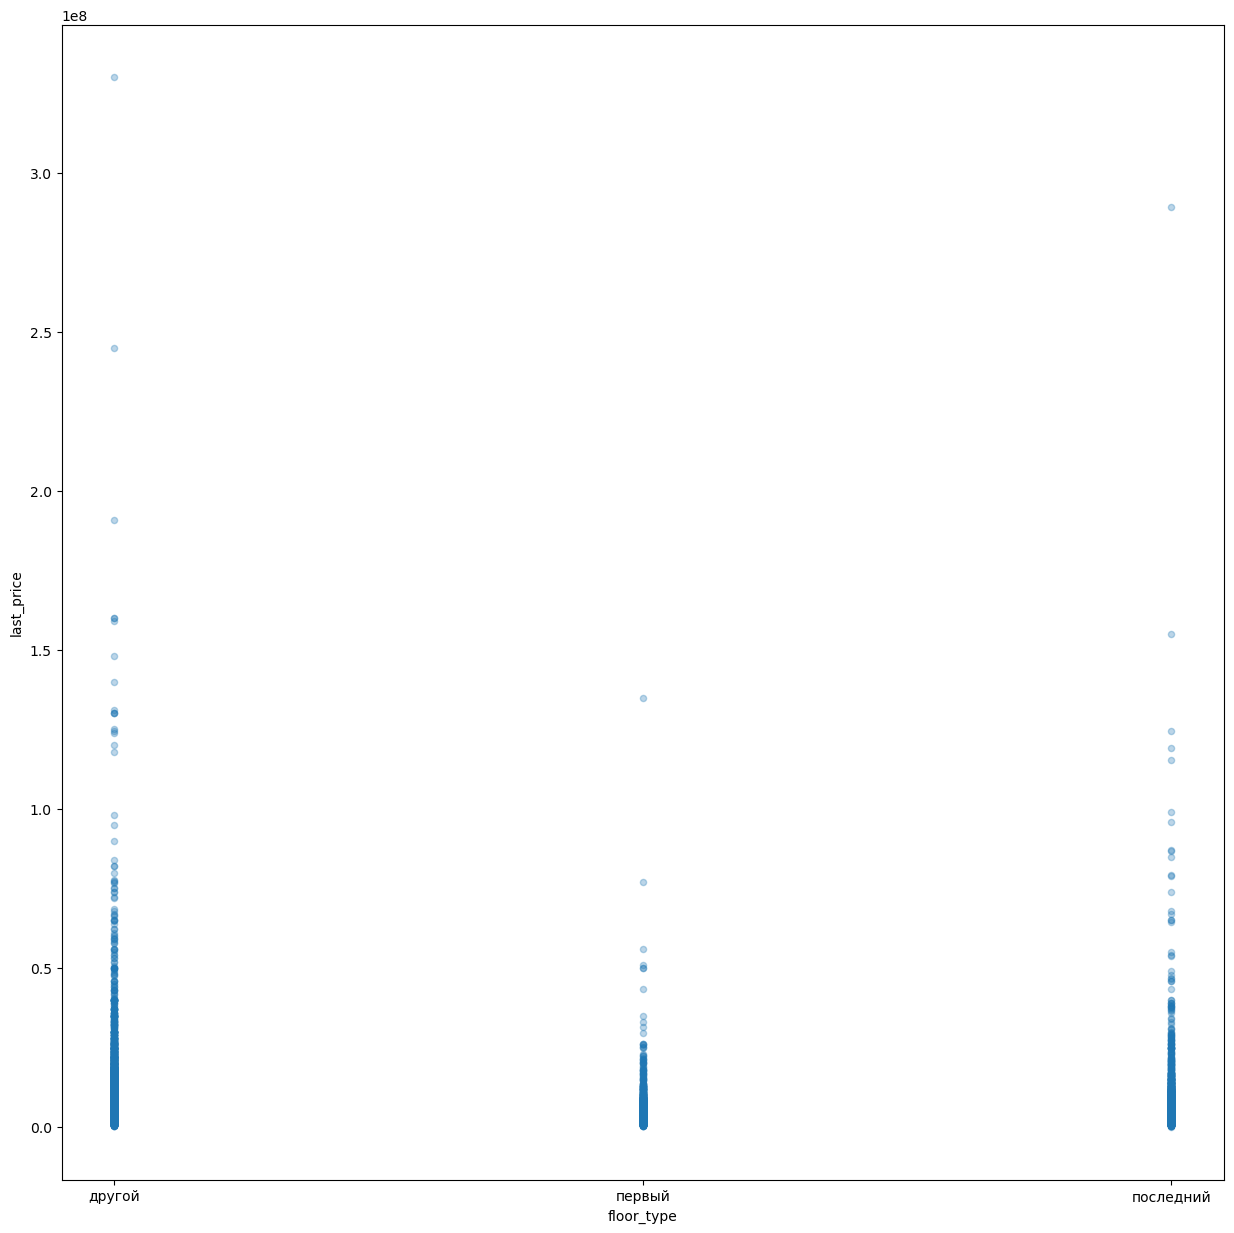

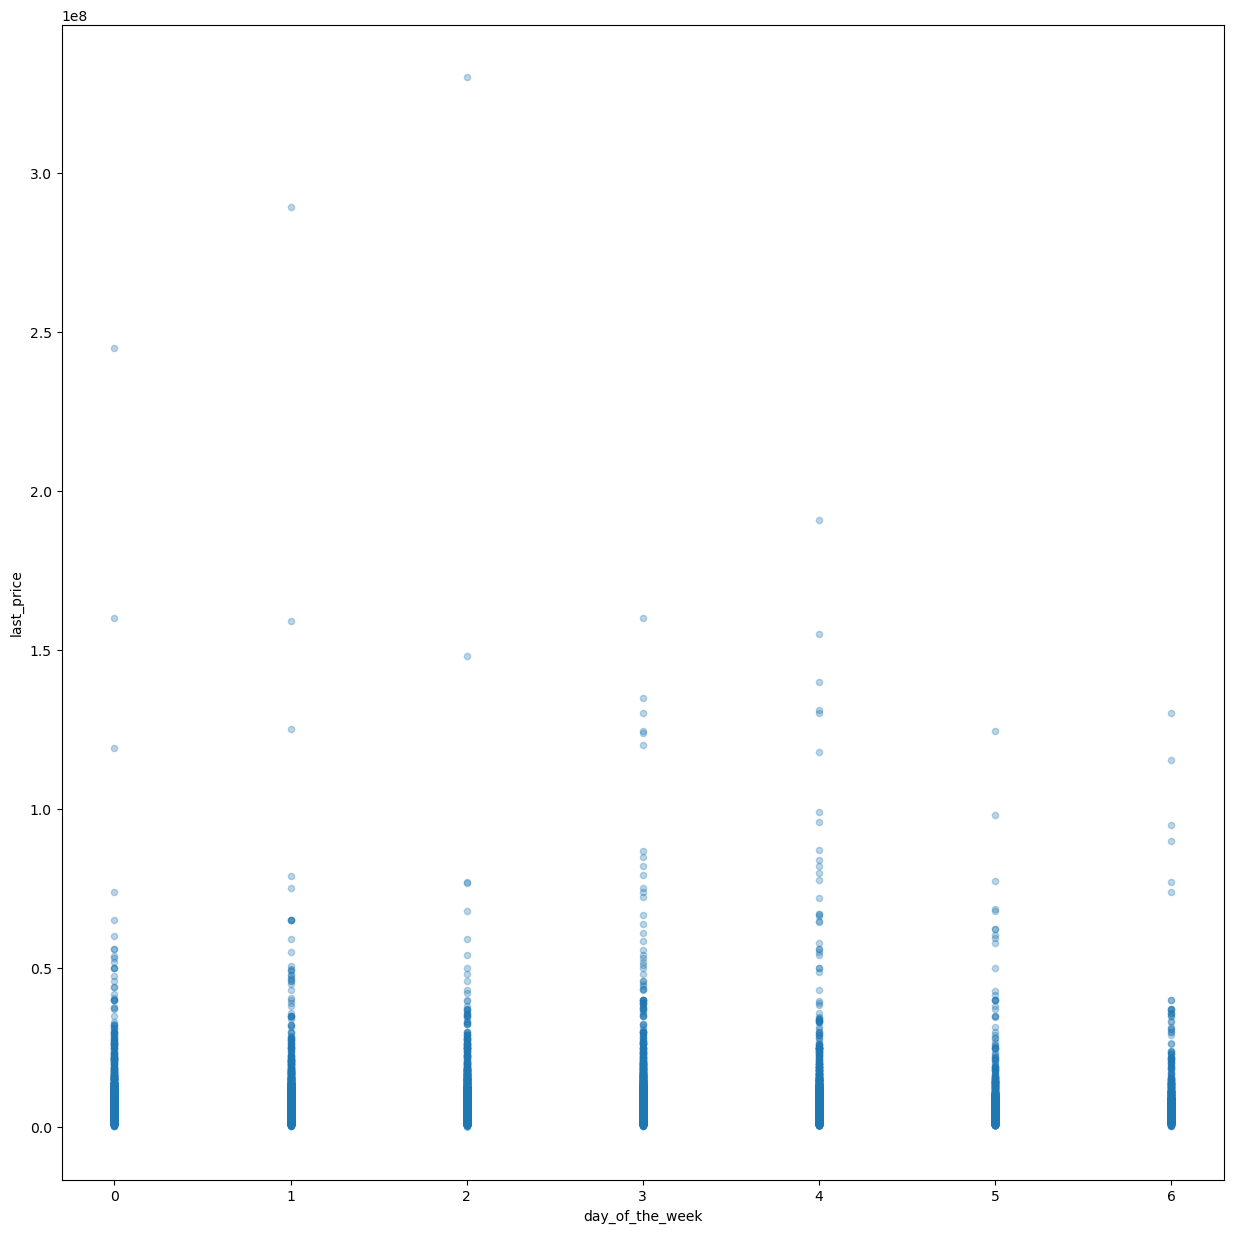

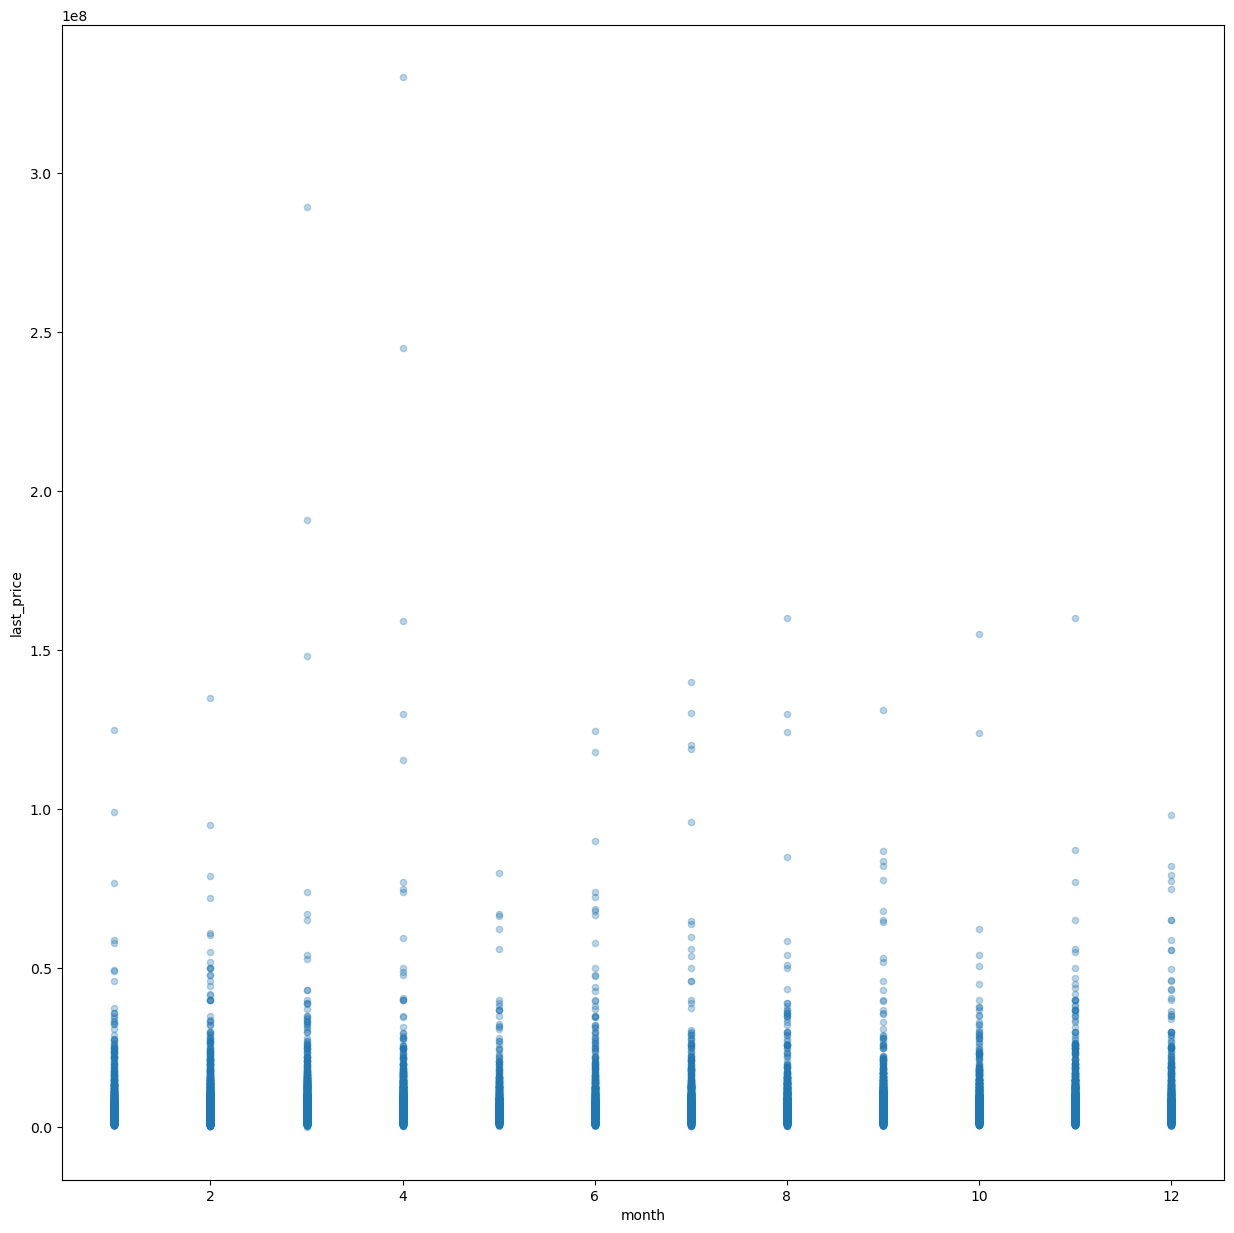

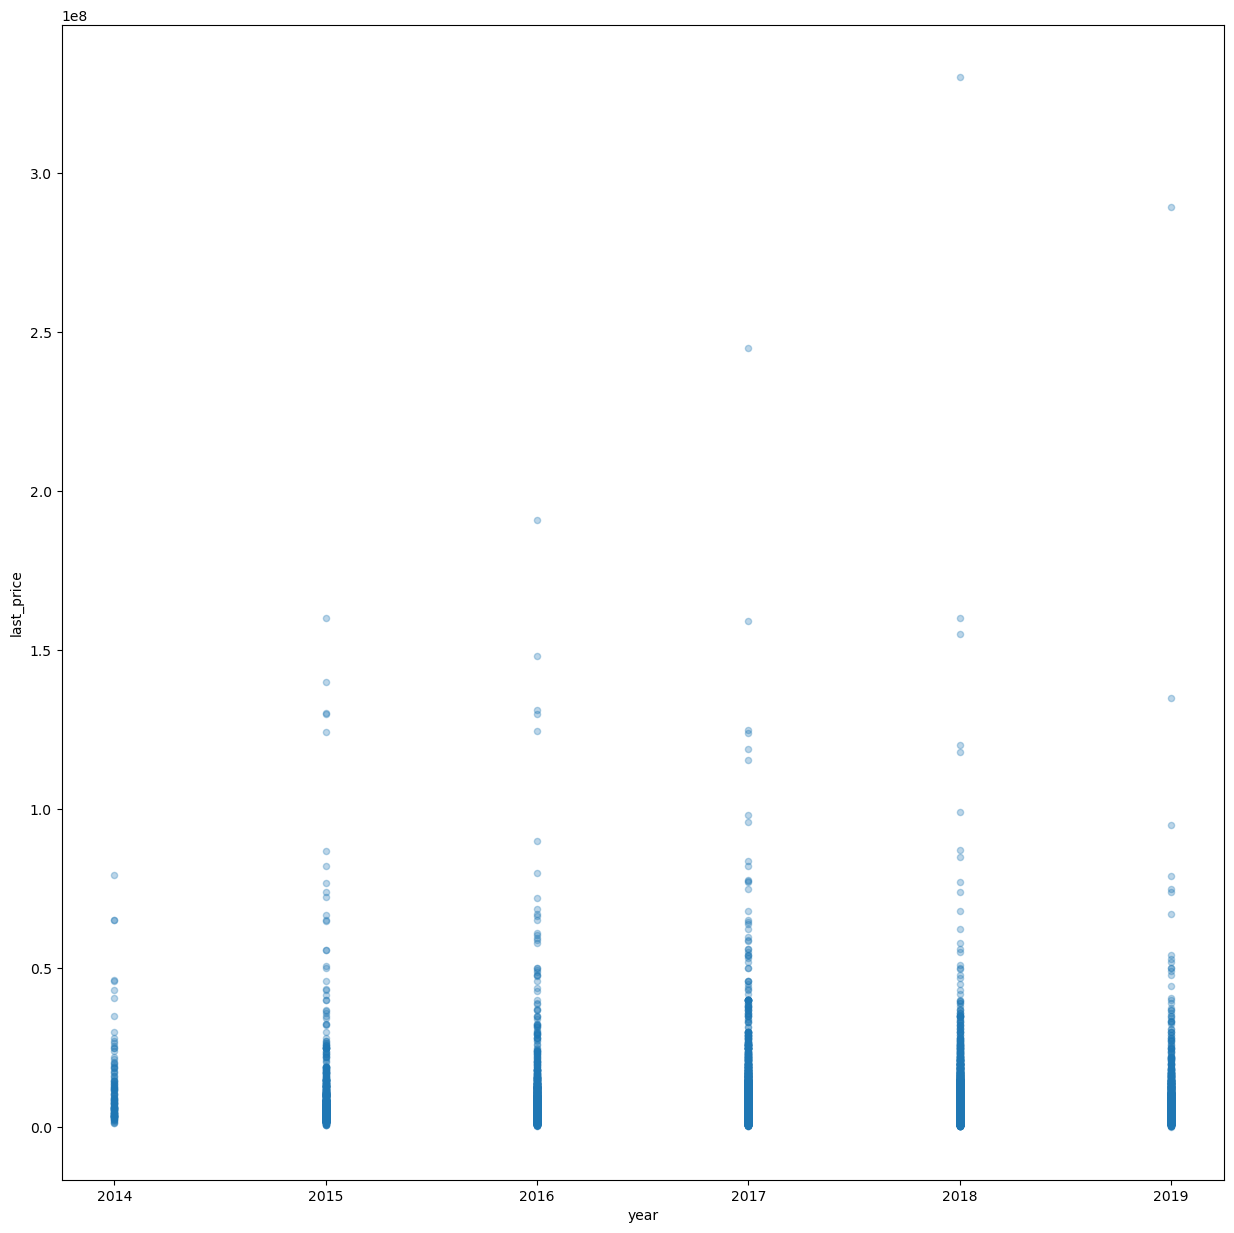

In [46]:
columns =['total_area', 'living_area', 'kitchen_area', 'rooms', 'floor_type','day_of_the_week','month','year']
for column in columns:
    data.plot(x=column, y='last_price', kind='scatter', alpha=0.3, figsize =(15,15)) 

По построенным графикам видим:
- Завистимость цены есть от площади объекта, чем площадь больше - тем цена выше, что логично;
- Стоимость 3, 4, 5 комнатных квартир выше чем 1, 2 и 6 комнатных;
- Стоимость квартир на Последнем и Других этажах значительно выше чем на Первом этаже;
- В будни размещают более дорогие квартиры на продажу, чем в выходные;
- В Марте и Апреле были высталенны самые дорогие объекты;
- С течением времени недвижимость дорожает, но в 2018 году было объяввление со стоимостью выше чем в 2019.

Так же посмотрим на корреляцию по числовым параметрам:

In [47]:
data[['last_price','total_area', 'living_area', 'kitchen_area', 'rooms', 'floor_type','day_of_the_week','month','year']].corr() 

,last_price,total_area,living_area,kitchen_area,rooms,day_of_the_week,month,year
last_price,1.000000,0.680301,0.602204,0.528291,0.386089,-0.002426,0.001376,-0.050037
total_area,0.680301,1.000000,0.936287,0.636050,0.771565,-0.008515,0.007926,-0.090424
living_area,0.602204,0.936287,1.000000,0.443616,0.849440,-0.006931,0.001883,-0.079338
kitchen_area,0.528291,0.636050,0.443616,1.000000,0.286661,-0.007714,0.008583,-0.061194
rooms,0.386089,0.771565,0.849440,0.286661,1.000000,-0.004033,-0.001133,-0.055656
day_of_the_week,-0.002426,-0.008515,-0.006931,-0.007714,-0.004033,1.000000,0.012327,-0.003269
month,0.001376,0.007926,0.001883,0.008583,-0.001133,0.012327,1.000000,-0.272595
year,-0.050037,-0.090424,-0.079338,-0.061194,-0.055656,-0.003269,-0.272595,1.000000


По первому столбцу можем сделать вывод что:
 - Стоимость однозначно зависит от площади при том с увеличением площади растет и цена объекта недвижимости;
 - Так же видим отрицательную корреляцию День недели и Год, но она столь мала что на нее мы не можем опереться.

Посчитаем среднюю цену одного квадратного метра в 10 населённых пунктах с наибольшим числом объявлений. Выделим населённые пункты с самой высокой и низкой стоимостью квадратного метра. 

In [48]:
data_pivot_top10 = data.pivot_table(index='locality_name',values='last_price',aggfunc=['mean','count'])

,last_price,count
locality_name,,
Санкт-Петербург,7.656214e+06,15533
Пушкин,6.372484e+06,368
поселок Парголово,4.477609e+06,326
деревня Кудрово,4.234158e+06,299
поселок Шушары,4.109809e+06,439
Колпино,3.866289e+06,337
Всеволожск,3.789068e+06,398
поселок Мурино,3.654697e+06,552
Гатчина,3.488337e+06,307


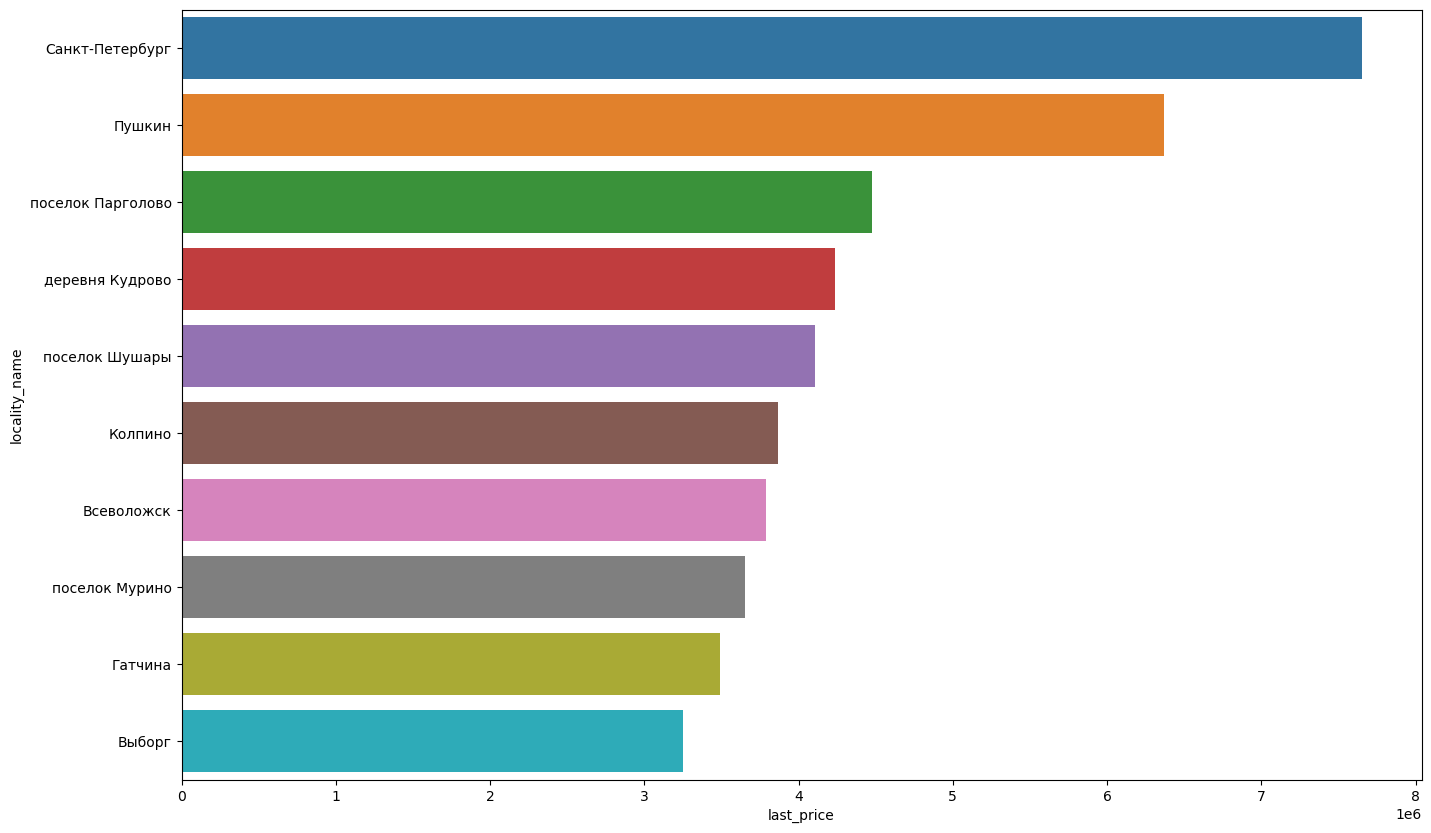

In [57]:
data_pivot_top10.columns = ['last_price','count']
data_pivot_top10 = data_pivot_top10.sort_values(by = 'count', ascending= False).head(10)
data_pivot_top10 = data_pivot_top10.sort_values(by = 'last_price', ascending= False)
display(data_pivot_top10)
import seaborn
plt.figure(figsize=(16, 10))
seaborn.barplot(x=data_pivot_top10['last_price'], y=data_pivot_top10.index)
plt.show()

В полученном рейтинге видим, что в Топ 5 по стоимости квадратного метра вошли Санкт-Петербург, Пушкин, поселок Парголово, деревня Кудрово, поселок Шушары.

Выделим квартиры в Санкт-Петербурге и посмотрим как зависит стоимость квадратного метра от расстояния до центра города.

array([[<AxesSubplot:xlabel='distance_in_km', ylabel='distance_in_km'>,
        <AxesSubplot:xlabel='price_one_meter', ylabel='distance_in_km'>],
       [<AxesSubplot:xlabel='distance_in_km', ylabel='price_one_meter'>,
        <AxesSubplot:xlabel='price_one_meter', ylabel='price_one_meter'>]],
      dtype=object)

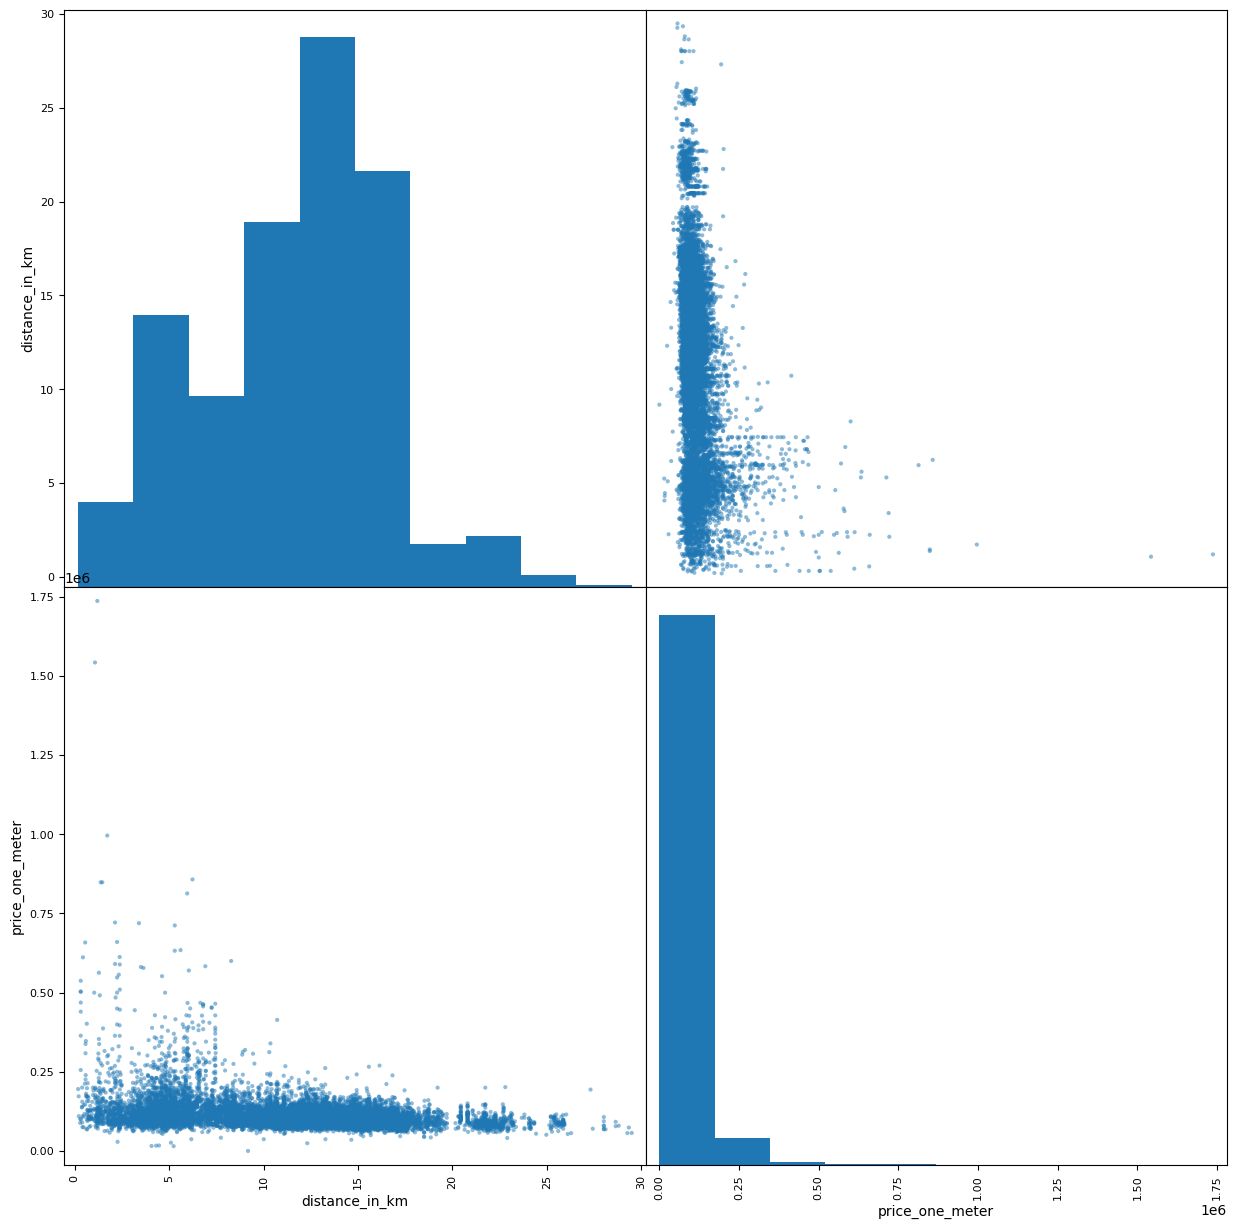

In [50]:
data_spb = data.loc[data['locality_name'] == 'Санкт-Петербург']
data_spb = data_spb[['distance_in_km','price_one_meter']]
pd.plotting.scatter_matrix(data_spb, figsize=(15, 15)) 

Попробуем исключить значения со стоимостью квадратного метра свыше 500 000 и посмотрим как измениться наш график

<AxesSubplot:xlabel='price_one_meter', ylabel='distance_in_km'>

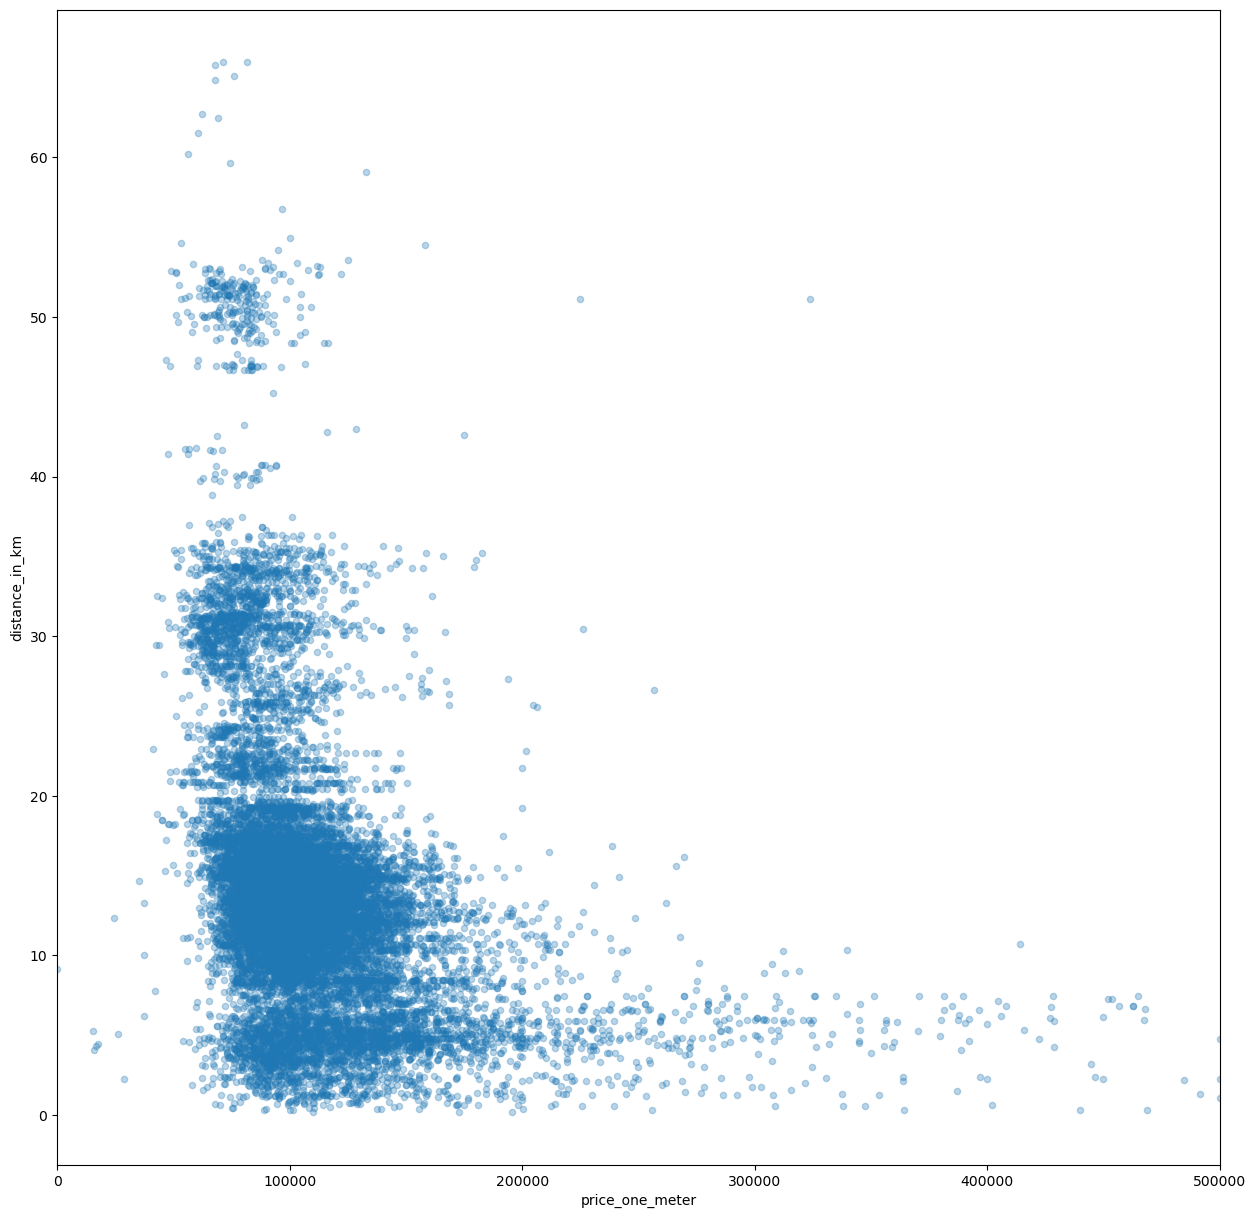

In [51]:
data.plot(x='price_one_meter', y='distance_in_km', xlim = (0,500000), kind = 'scatter', alpha=0.3, figsize =(15,15)) 

Видим что, чем ближе к центру города тем квартиры дороже.

### Общий вывод

Мы провели исследование, как различные факторы влияют на стоимость объектов недвижимости.
Входные данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет.

Выделили 10 населенных пунктов с наибольшим кольичеством объявлений и стоимостью квадратного метра

,last_price,count
locality_name,,
Санкт-Петербург,7.656214e+06,15533
Пушкин,6.372484e+06,368
поселок Парголово,4.477609e+06,326
деревня Кудрово,4.234158e+06,299
поселок Шушары,4.109809e+06,439
Колпино,3.866289e+06,337
Всеволожск,3.789068e+06,398
поселок Мурино,3.654697e+06,552
Гатчина,3.488337e+06,307


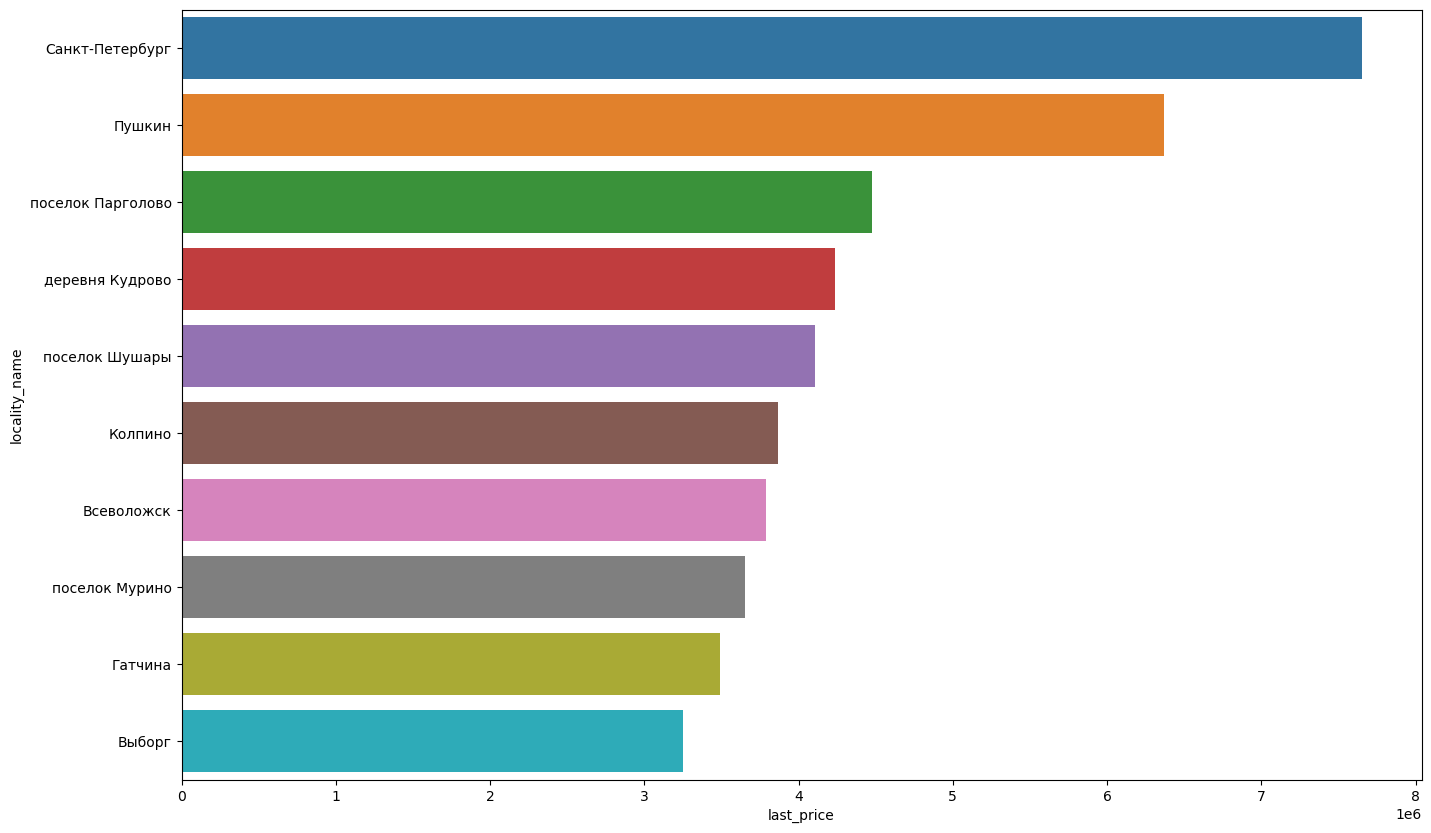

In [58]:
data_pivot_top10.columns = ['last_price','count']
data_pivot_top10 = data_pivot_top10.sort_values(by = 'count', ascending= False).head(10)
data_pivot_top10 = data_pivot_top10.sort_values(by = 'last_price', ascending= False)
display(data_pivot_top10)
import seaborn
plt.figure(figsize=(16, 10))
seaborn.barplot(x=data_pivot_top10['last_price'], y=data_pivot_top10.index)
plt.show()

Перед проведением исследования выдвинули несколько гипотез. 
От чего зависит стоимость квартиры:
* общей площади;
* жилой площади;
* площади кухни;
* количество комнат;
* типа этажа, на котором расположена квартира (первый, последний, другой);
* даты размещения (день недели, месяц, год);
* расстояния до центра города.

**Общие рекомендации:**
1. Стоимость объекта напрямую зависить от:
* Общей площади;
* Жилой площади;
* Площади кухни.
2. Так же удалось выявить закономерность, чем ближе объект к центру города, тем выше стоимость квадратного метра.